In [2]:
import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
from scipy.stats import pearsonr
from scipy.stats import spearmanr
%matplotlib inline

Libraries implemented to preprocesing of the data, in the next steps I'm gonna create the variables used to work with it.


In [3]:
### Set-up - Define file location
filename = 'N-CMAPSS_DS02-006.h5'

In [4]:
# Time tracking, Operation time (min):  0.003
t = time.process_time()  

# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print('')
print("Operation time (min): " , (time.process_time()-t)/60)
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))


Operation time (min):  0.11770833333333333

W shape: (6517190, 4)
X_s shape: (6517190, 14)
X_v shape: (6517190, 14)
T shape: (6517190, 10)
A shape: (6517190, 4)


In [7]:
df_A = DataFrame(data=A, columns=A_var)
df_A.describe()

unit         cycle            Fc            hs
count  6.517190e+06  6.517190e+06  6.517190e+06  6.517190e+06
mean   1.166711e+01  3.692344e+01  2.885376e+00  2.424109e-01
std    6.039334e+00  2.187185e+01  3.867783e-01  4.285416e-01
min    2.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00
25%    5.000000e+00  1.800000e+01  3.000000e+00  0.000000e+00
50%    1.100000e+01  3.600000e+01  3.000000e+00  0.000000e+00
75%    1.800000e+01  5.400000e+01  3.000000e+00  0.000000e+00
max    2.000000e+01  8.900000e+01  3.000000e+00  1.000000e+00

In [6]:


print('Engine units in df: ', np.unique(df_A['unit']))

Engine units in df:  [ 2.  5. 10. 11. 14. 15. 16. 18. 20.]


In [7]:
for i in np.unique(df_A['unit']):
    print('Unit: ' + str(i) + ' - Number of flight cyles (t_{EOF}): ', len(np.unique(df_A.loc[df_A['unit'] == i, 'cycle'])))
    #np.unique(df_A.loc[df_A['unit'] == i, 'cycle'])

Unit: 2.0 - Number of flight cyles (t_{EOF}):  75
Unit: 5.0 - Number of flight cyles (t_{EOF}):  89
Unit: 10.0 - Number of flight cyles (t_{EOF}):  82
Unit: 11.0 - Number of flight cyles (t_{EOF}):  59
Unit: 14.0 - Number of flight cyles (t_{EOF}):  76
Unit: 15.0 - Number of flight cyles (t_{EOF}):  67
Unit: 16.0 - Number of flight cyles (t_{EOF}):  63
Unit: 18.0 - Number of flight cyles (t_{EOF}):  71
Unit: 20.0 - Number of flight cyles (t_{EOF}):  66


In [25]:
unique_units = np.unique(df_A['unit'])

for unit in unique_units:
    flight_classes = np.unique(df_A[df_A['unit'] == unit]['Fc'])
    print(f'Unit: {unit} - Flight Classes: {flight_classes}')

Unit: 2.0 - Flight Classes: [3.]
Unit: 5.0 - Flight Classes: [3.]
Unit: 10.0 - Flight Classes: [3.]
Unit: 11.0 - Flight Classes: [3.]
Unit: 14.0 - Flight Classes: [1.]
Unit: 15.0 - Flight Classes: [2.]
Unit: 16.0 - Flight Classes: [3.]
Unit: 18.0 - Flight Classes: [3.]
Unit: 20.0 - Flight Classes: [3.]


In [8]:
df_W = DataFrame(data=W, columns=W_var)
df_W['unit'] = df_A['unit'].values

In [27]:
def plot_df_single_color(data, variables, labels, size=12, labelsize=17, name=None):
    """
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)    
    fig  = plt.figure(figsize=(size,max(size,rows*2))) 
    
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        ax.plot(data[variables[n]], marker='.', markerfacecolor='none', alpha = 0.7)
        ax.tick_params(axis='x', labelsize=labelsize)
        ax.tick_params(axis='y', labelsize=labelsize)
        plt.ylabel(labels[n], fontsize=labelsize)
        plt.xlabel('Time [s]', fontsize=labelsize)
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

In [28]:
def plot_df_color_per_unit(data, variables, labels, size=7, labelsize=17, option='Time', name=None):
    """
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'green'} 
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        if n==0:
            ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

<Figure size 640x480 with 0 Axes>

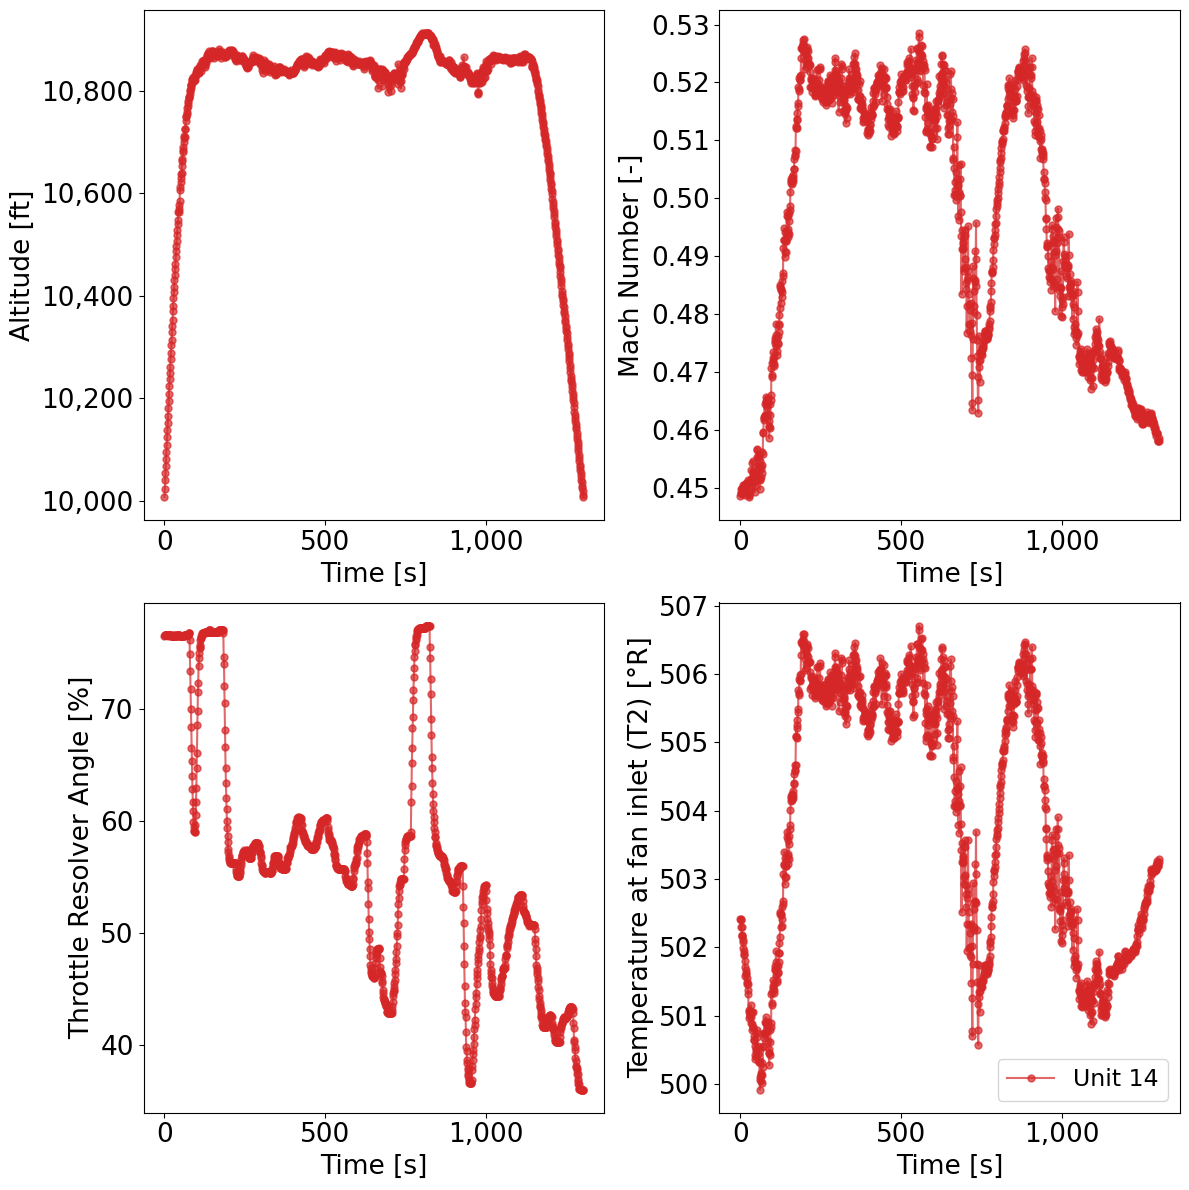

In [29]:
df_W_u = df_W.loc[(df_A.unit == 14) & (df_A.cycle == 7)]
df_W_u.reset_index(inplace=True, drop=True)
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
plot_df_color_per_unit(df_W_u, W_var , labels, size=12, labelsize=19)

In [12]:
def plot_kde(leg, variables, labels, size, units, df_W, df_A, labelsize=17, name=None):
    """
    """
    plt.clf()
       
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs = gridspec.GridSpec(rows, cols)
    
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'green'} 
    
    fig = plt.figure(figsize=(size,max(size,rows*2)))       

    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for k, elem in enumerate(units):
            sns.kdeplot(df_W.loc[df_A['unit'] == elem, variables[n]],
                        color=color_dic_unit[leg[k]], shade=True, gridsize=100)  
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
        
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))        
        plt.xlabel(labels[n], fontsize=labelsize)
        plt.ylabel('Density [-]', fontsize=labelsize)
        if n==0:
            plt.legend(leg, fontsize=labelsize-4, loc=0)
        else:
            plt.legend(leg, fontsize=labelsize-4, loc=2)
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)    
    plt.show()
    plt.close()

<Figure size 640x480 with 0 Axes>

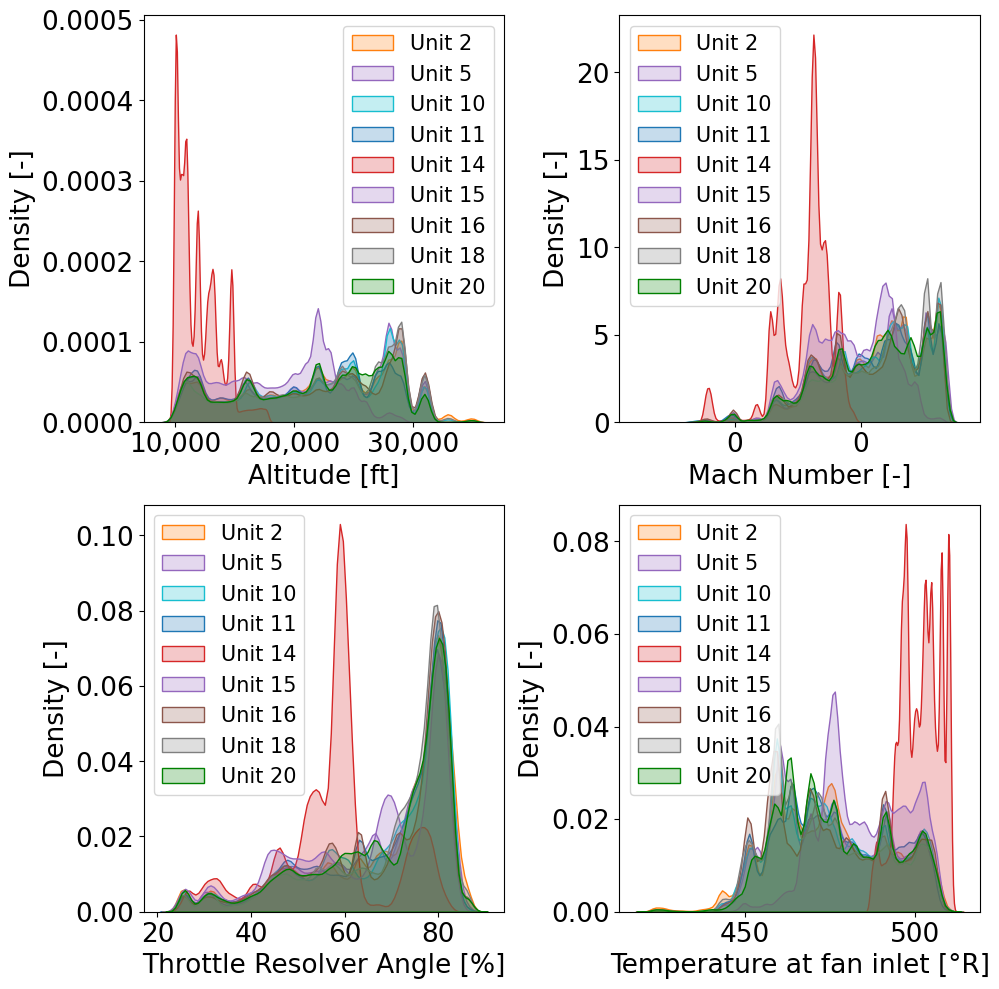

In [13]:
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']
size = 10

units = list(np.unique(df_A['unit']))
leg = ['Unit ' + str(int(u)) for u in units]

plot_kde(leg, variables, labels, size, units, df_W, df_A, labelsize=19)

<Figure size 640x480 with 0 Axes>

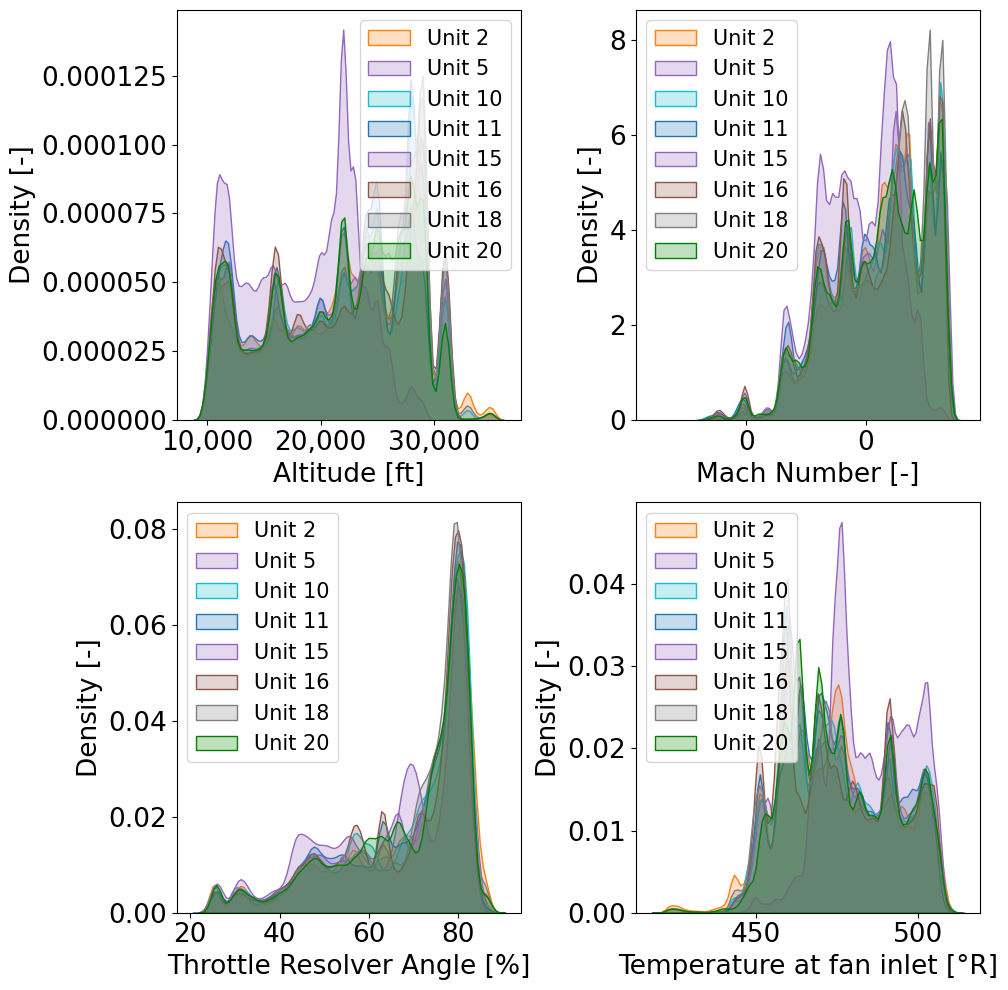

In [30]:
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']
size = 10

# Specify the unit you want to show (Unit 2)
units_to_show = [2, 5, 10, 11, 15, 16, 18, 20]

# Create legend labels for the selected unit
leg = ['Unit ' + str(int(unit)) for unit in units_to_show]

plot_kde(leg, variables, labels, size, units_to_show, df_W, df_A, labelsize=19)


<Figure size 640x480 with 0 Axes>

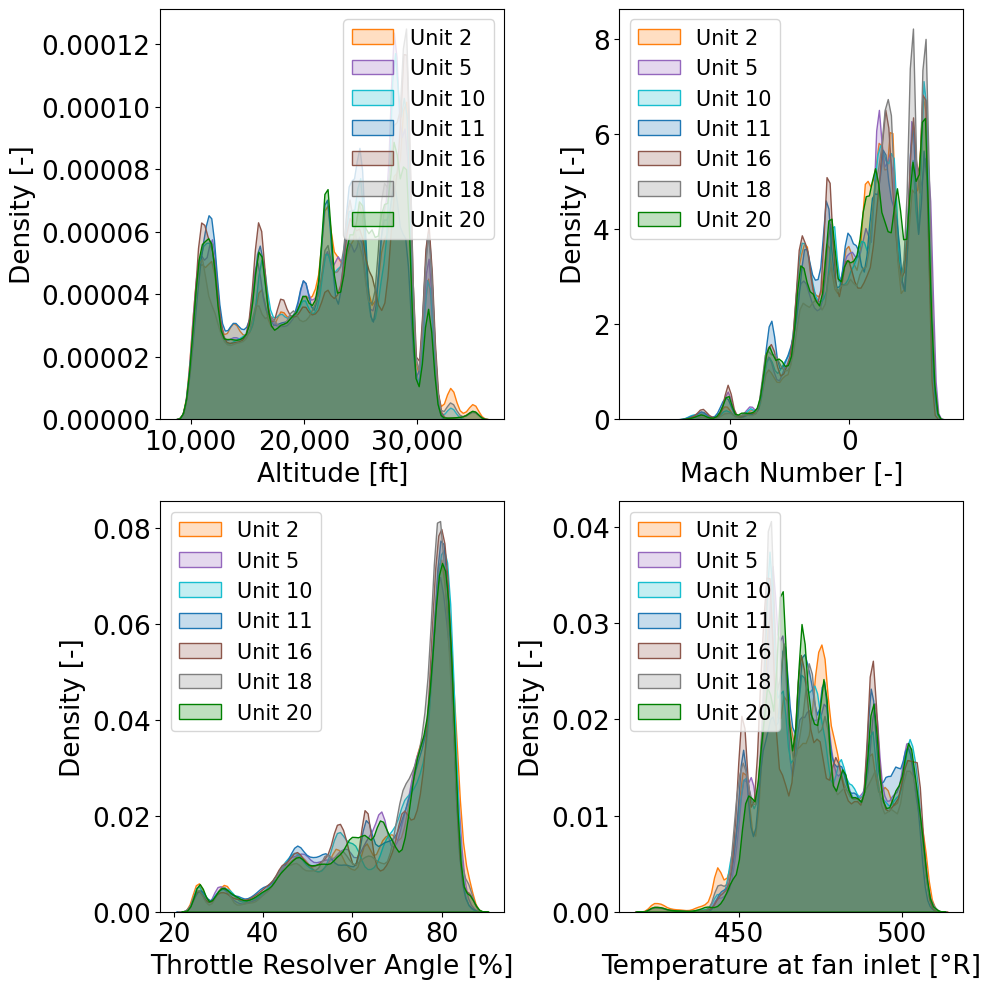

In [33]:
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']
size = 10

# Specify the unit you want to show (Unit 2)
units_to_show = [2, 5, 10, 11, 16, 18, 20]

# Create legend labels for the selected unit
leg = ['Unit ' + str(int(unit)) for unit in units_to_show]

plot_kde(leg, variables, labels, size, units_to_show, df_W, df_A, labelsize=19)

<Figure size 640x480 with 0 Axes>

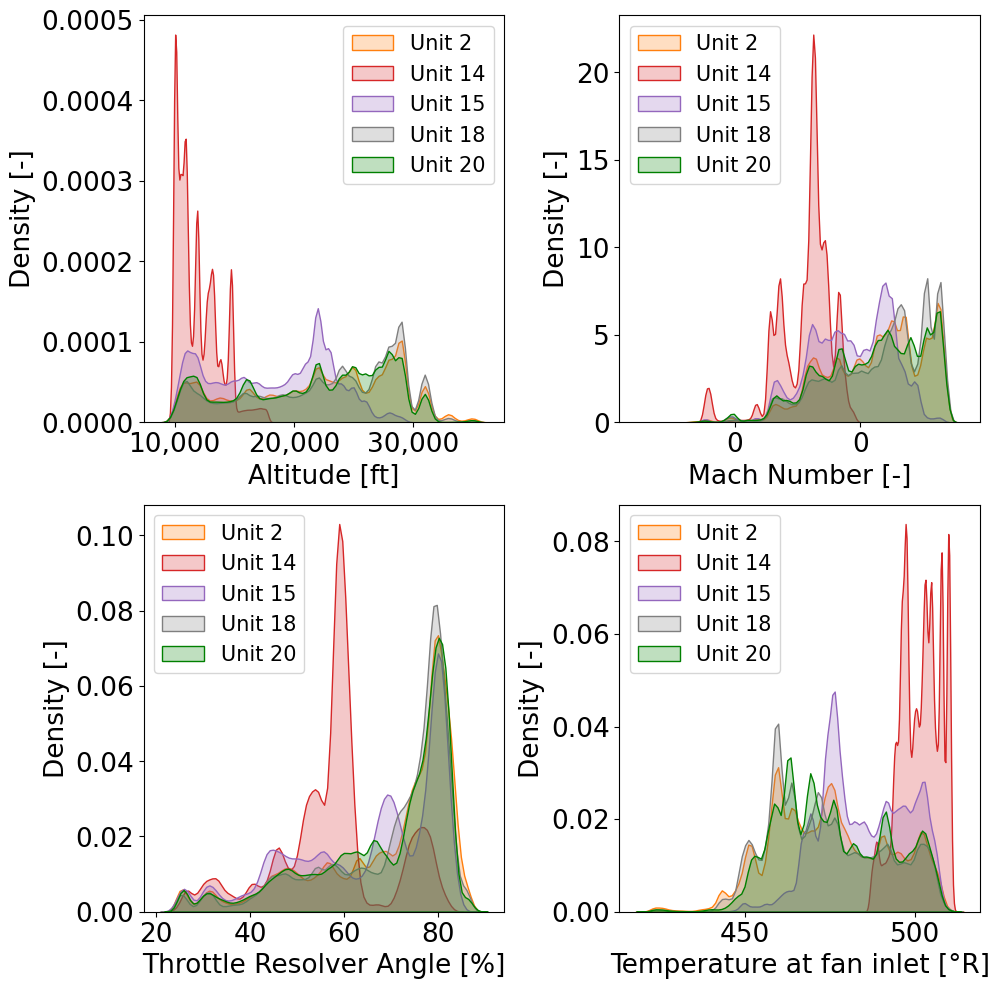

In [31]:
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']
size = 10

# Specify the unit you want to show (Unit 2)
units_to_show = [2, 14, 15, 18, 20]

# Create legend labels for the selected unit
leg = ['Unit ' + str(int(unit)) for unit in units_to_show]

plot_kde(leg, variables, labels, size, units_to_show, df_W, df_A, labelsize=19)

<Figure size 640x480 with 0 Axes>

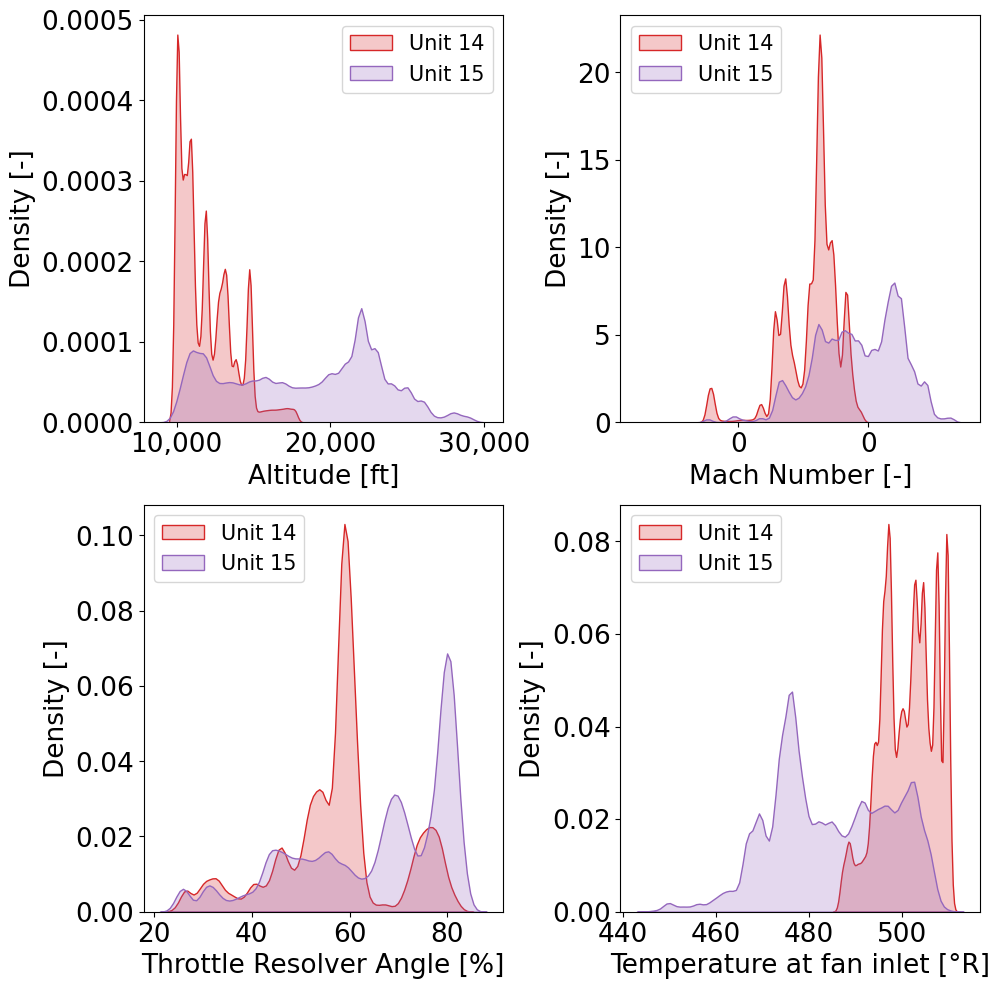

In [32]:
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']
size = 10

# Specify the unit you want to show (Unit 2)
units_to_show = [14, 15]

# Create legend labels for the selected unit
leg = ['Unit ' + str(int(unit)) for unit in units_to_show]

plot_kde(leg, variables, labels, size, units_to_show, df_W, df_A, labelsize=19)

In [17]:
from scipy.stats import norm

def plot_kde_with_normal(leg, variables, labels, size, units, df_W, df_A, labelsize=17, name=None):
    plt.clf()

    input_dim = len(variables)
    cols = min(np.floor(input_dim ** 0.5).astype(int), 4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs = gridspec.GridSpec(rows, cols)

    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'}

    fig = plt.figure(figsize=(size, max(size, rows * 2)))

    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for k, elem in enumerate(units):
            sns.kdeplot(
                df_W.loc[df_A['unit'] == elem, variables[n]],
                color=color_dic_unit['Unit ' + str(int(elem))],  # Use the dictionary here
                shade=True,
                gridsize=100
            )

            # Generate normal distribution curve parameters based on the data
            data = df_W.loc[df_A['unit'] == elem, variables[n]]
            mu, std = norm.fit(data)
            xmin, xmax = plt.xlim()
            x = np.linspace(xmin, xmax, 100)
            p = norm.pdf(x, mu, std)  # PDF of the fitted normal distribution
            plt.plot(x, p, 'k', linewidth=2)  # Overlay the normal distribution curve

            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)

        ax.get_xaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.xlabel(labels[n], fontsize=labelsize)
        plt.ylabel('Density [-]', fontsize=labelsize)

        if n == 0:
            plt.legend(leg, fontsize=labelsize-4, loc=0)
        else:
            plt.legend(leg, fontsize=labelsize-4, loc=2)

    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)
    plt.show()
    plt.close()


<Figure size 640x480 with 0 Axes>

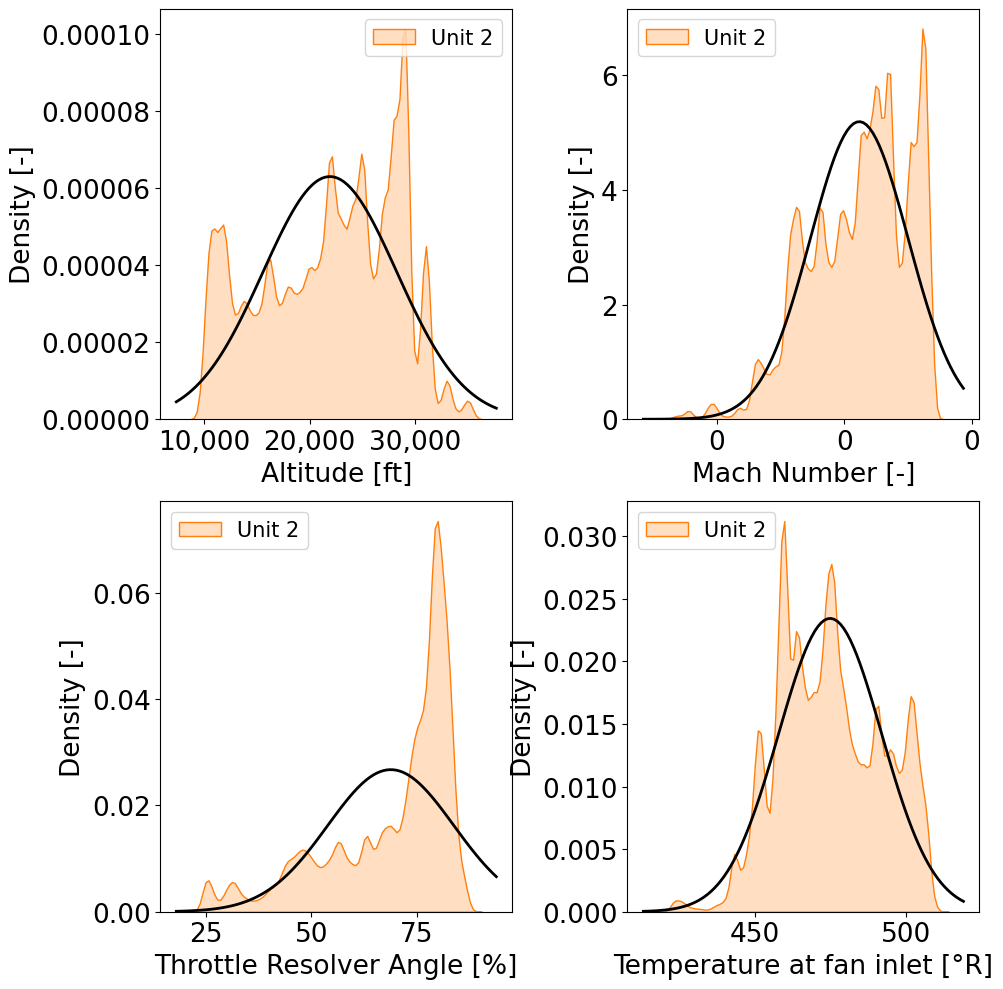

In [20]:
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']
size = 10

# Especifica las unidades que deseas mostrar (Unidades 2, 5 y 10)
units_to_show = [2]

# Crea etiquetas de leyenda para las unidades seleccionadas
leg = ['Unit ' + str(int(unit)) for unit in units_to_show]

plot_kde_with_normal(leg, variables, labels, size, units_to_show, df_W, df_A, labelsize=19)


<Figure size 640x480 with 0 Axes>

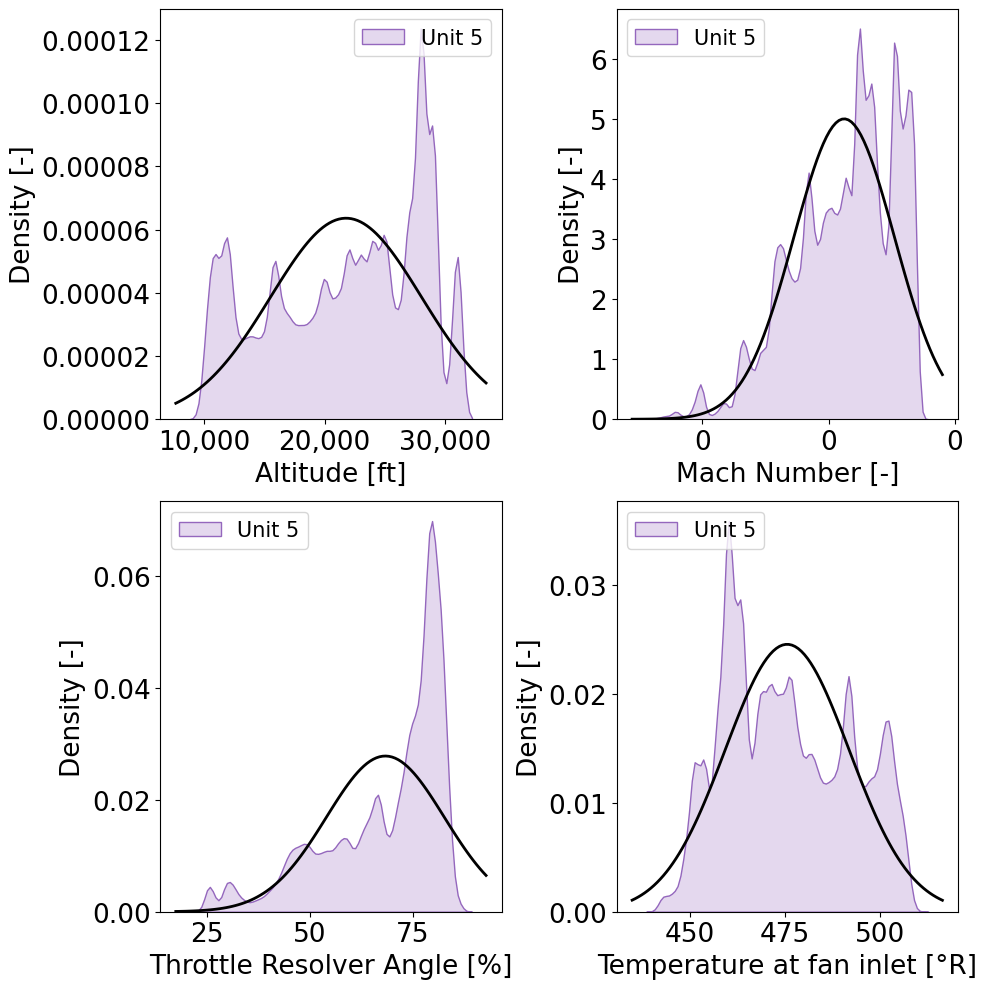

In [21]:
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']
size = 10

# Especifica las unidades que deseas mostrar (Unidades 2, 5 y 10)
units_to_show = [5]

# Crea etiquetas de leyenda para las unidades seleccionadas
leg = ['Unit ' + str(int(unit)) for unit in units_to_show]

plot_kde_with_normal(leg, variables, labels, size, units_to_show, df_W, df_A, labelsize=19)

<Figure size 640x480 with 0 Axes>

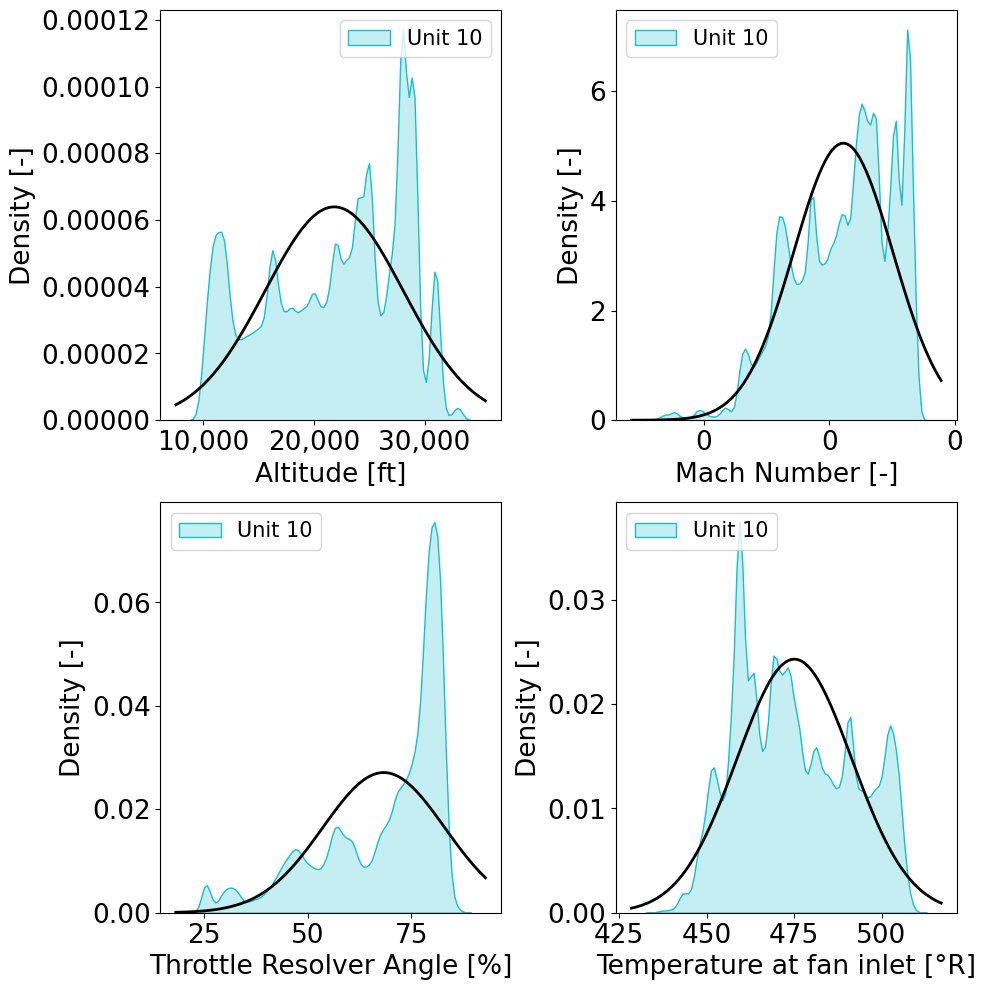

In [22]:
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']
size = 10

# Especifica las unidades que deseas mostrar (Unidades 2, 5 y 10)
units_to_show = [10]

# Crea etiquetas de leyenda para las unidades seleccionadas
leg = ['Unit ' + str(int(unit)) for unit in units_to_show]

plot_kde_with_normal(leg, variables, labels, size, units_to_show, df_W, df_A, labelsize=19)

<Figure size 640x480 with 0 Axes>

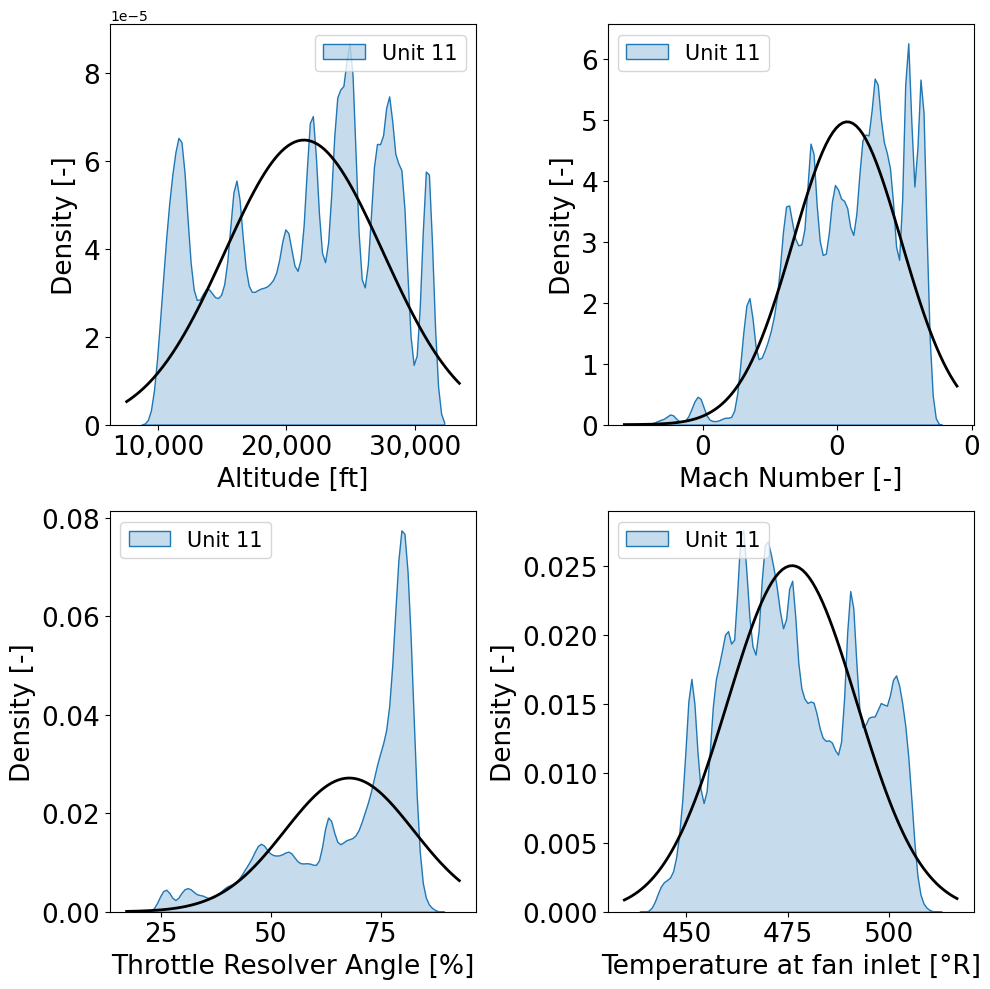

In [23]:
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']
size = 10

# Especifica las unidades que deseas mostrar (Unidades 2, 5 y 10)
units_to_show = [11]

# Crea etiquetas de leyenda para las unidades seleccionadas
leg = ['Unit ' + str(int(unit)) for unit in units_to_show]

plot_kde_with_normal(leg, variables, labels, size, units_to_show, df_W, df_A, labelsize=19)

<Figure size 640x480 with 0 Axes>

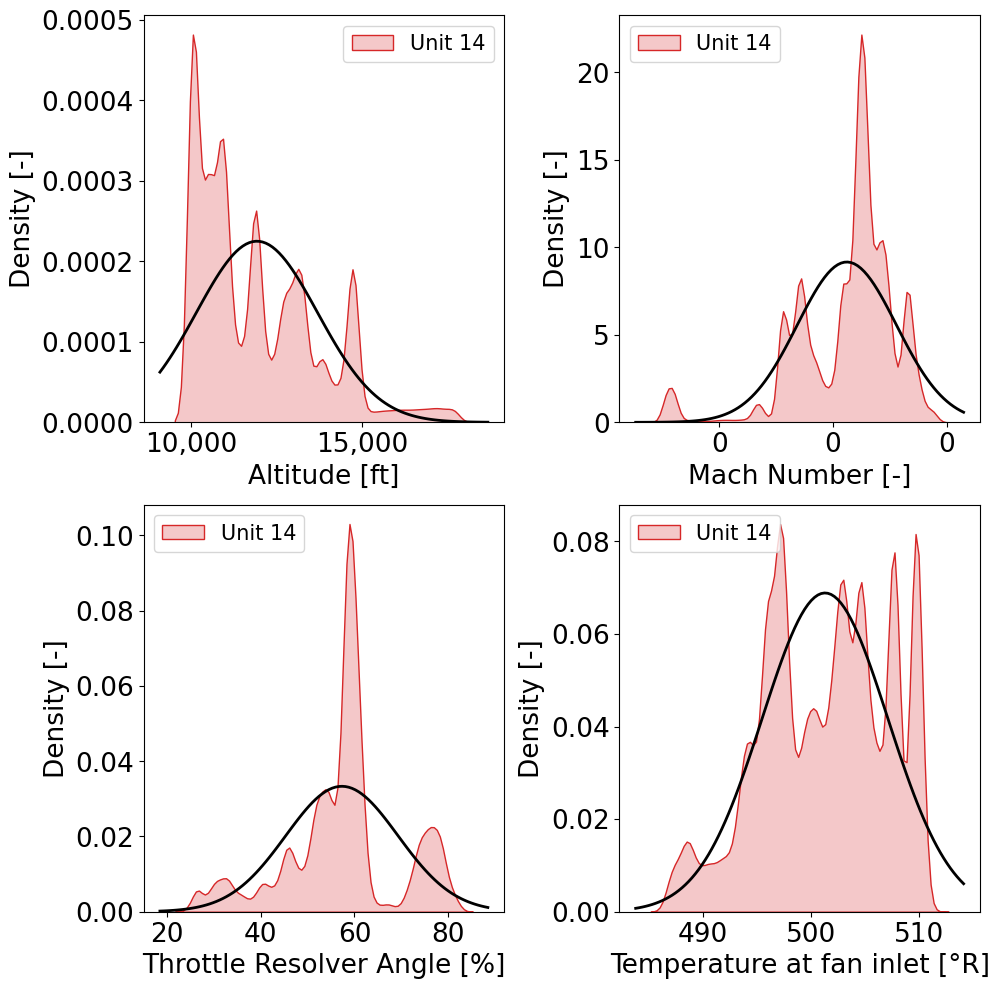

In [24]:
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']
size = 10

# Especifica las unidades que deseas mostrar (Unidades 2, 5 y 10)
units_to_show = [14]

# Crea etiquetas de leyenda para las unidades seleccionadas
leg = ['Unit ' + str(int(unit)) for unit in units_to_show]

plot_kde_with_normal(leg, variables, labels, size, units_to_show, df_W, df_A, labelsize=19)

<Figure size 640x480 with 0 Axes>

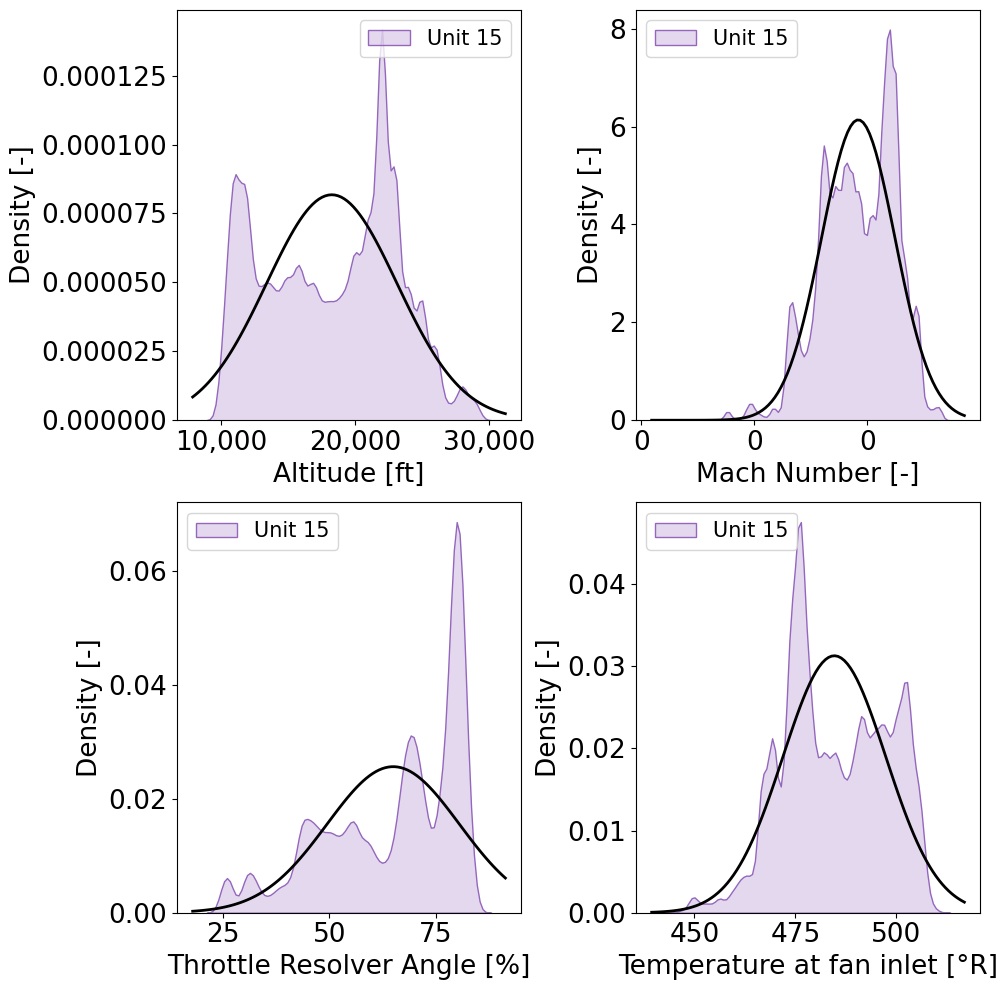

In [25]:
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']
size = 10

# Especifica las unidades que deseas mostrar (Unidades 2, 5 y 10)
units_to_show = [15]

# Crea etiquetas de leyenda para las unidades seleccionadas
leg = ['Unit ' + str(int(unit)) for unit in units_to_show]

plot_kde_with_normal(leg, variables, labels, size, units_to_show, df_W, df_A, labelsize=19)

<Figure size 640x480 with 0 Axes>

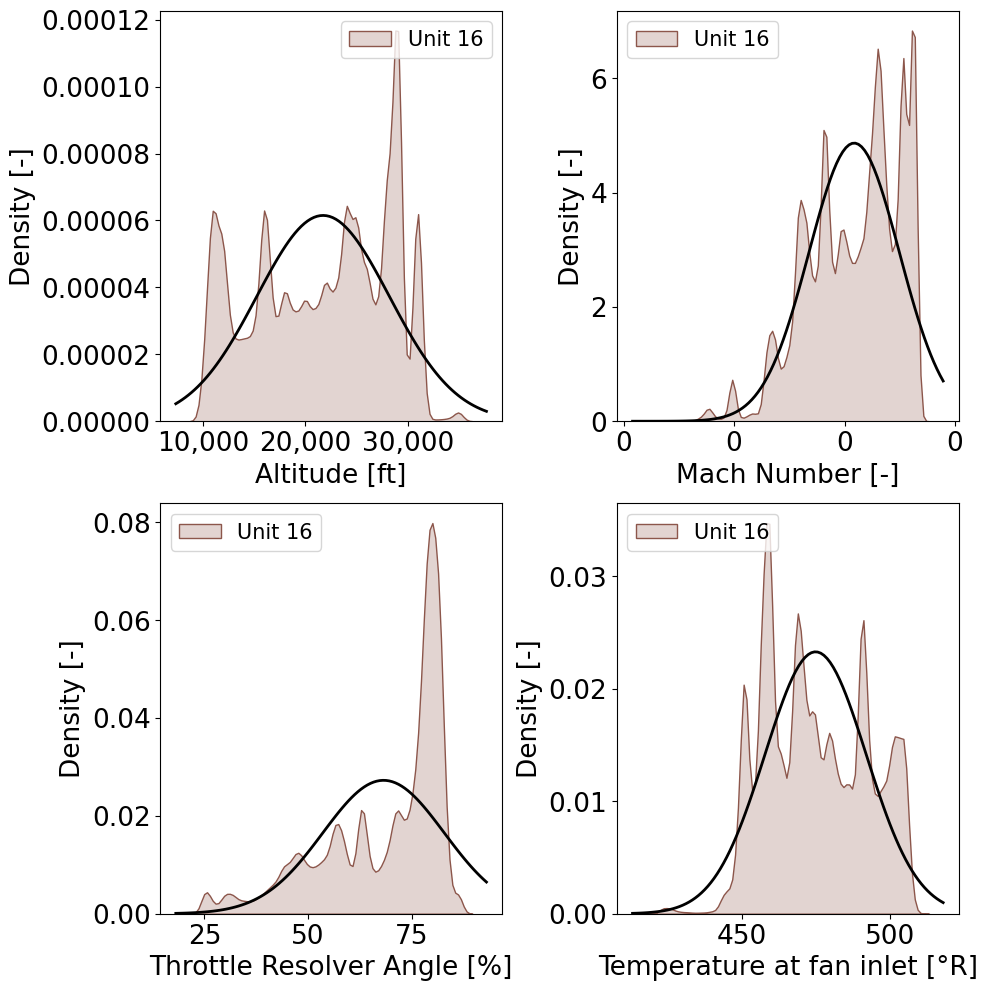

In [26]:
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']
size = 10

# Especifica las unidades que deseas mostrar (Unidades 2, 5 y 10)
units_to_show = [16]

# Crea etiquetas de leyenda para las unidades seleccionadas
leg = ['Unit ' + str(int(unit)) for unit in units_to_show]

plot_kde_with_normal(leg, variables, labels, size, units_to_show, df_W, df_A, labelsize=19)

<Figure size 640x480 with 0 Axes>

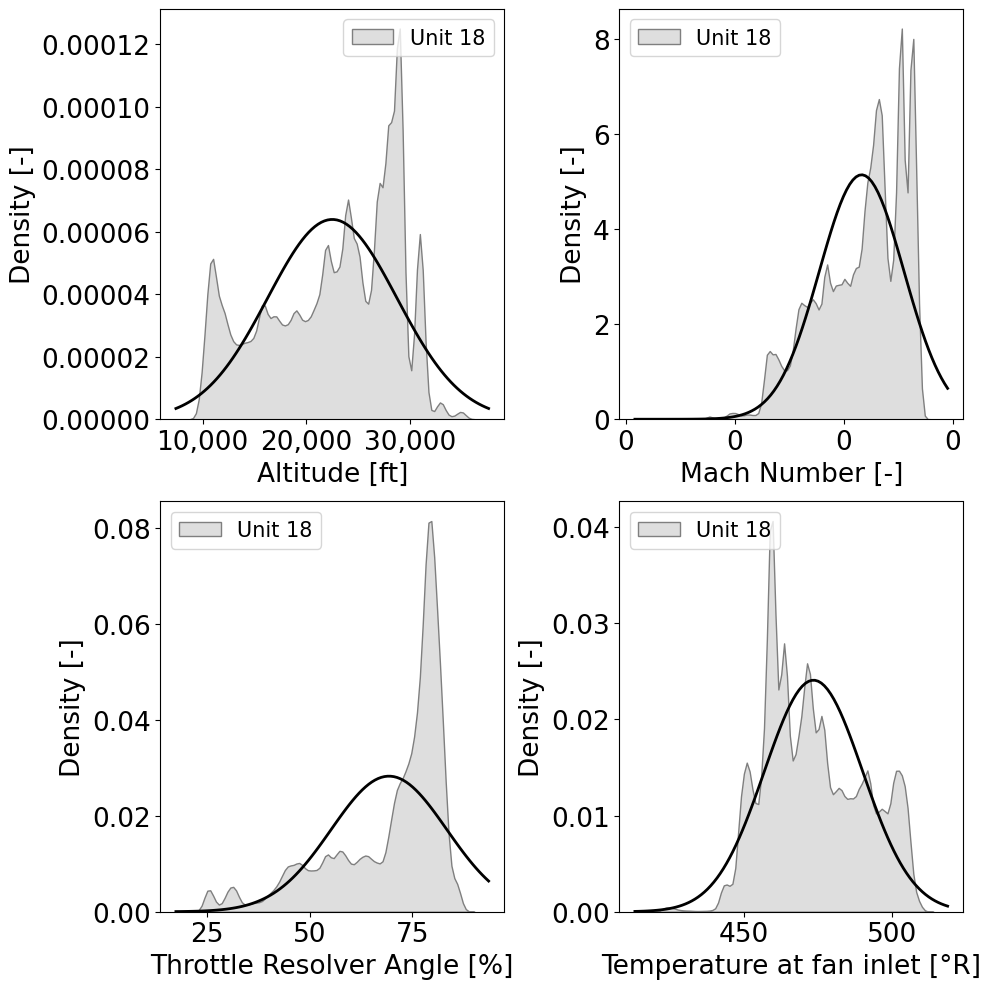

In [27]:
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']
size = 10

# Especifica las unidades que deseas mostrar (Unidades 2, 5 y 10)
units_to_show = [18]

# Crea etiquetas de leyenda para las unidades seleccionadas
leg = ['Unit ' + str(int(unit)) for unit in units_to_show]

plot_kde_with_normal(leg, variables, labels, size, units_to_show, df_W, df_A, labelsize=19)

<Figure size 640x480 with 0 Axes>

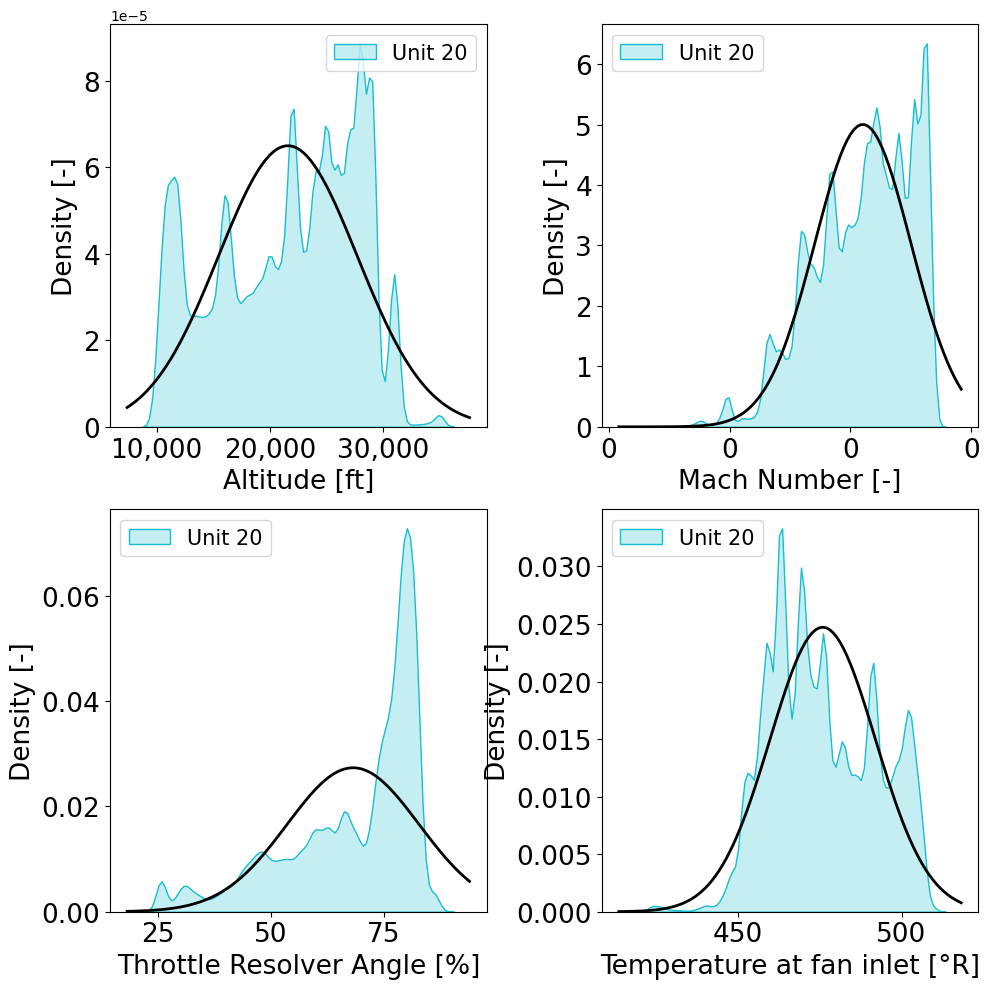

In [28]:
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']
size = 10

# Especifica las unidades que deseas mostrar (Unidades 2, 5 y 10)
units_to_show = [20]

# Crea etiquetas de leyenda para las unidades seleccionadas
leg = ['Unit ' + str(int(unit)) for unit in units_to_show]

plot_kde_with_normal(leg, variables, labels, size, units_to_show, df_W, df_A, labelsize=19)

In [10]:
df_T = DataFrame(data=T, columns=T_var) 
df_T['unit'] = df_A['unit'].values
df_T['cycle'] = df_A['cycle'].values
df_Ts = df_T.drop_duplicates()
df_Ts.describe()

fan_eff_mod  fan_flow_mod  LPC_eff_mod  LPC_flow_mod  HPC_eff_mod  \
count        648.0         648.0        648.0         648.0        648.0   
mean           0.0           0.0          0.0           0.0          0.0   
std            0.0           0.0          0.0           0.0          0.0   
min            0.0           0.0          0.0           0.0          0.0   
25%            0.0           0.0          0.0           0.0          0.0   
50%            0.0           0.0          0.0           0.0          0.0   
75%            0.0           0.0          0.0           0.0          0.0   
max            0.0           0.0          0.0           0.0          0.0   

       HPC_flow_mod  HPT_eff_mod  HPT_flow_mod  LPT_eff_mod  LPT_flow_mod  \
count         648.0   648.000000         648.0   648.000000    648.000000   
mean            0.0    -0.003271           0.0    -0.001792     -0.002024   
std             0.0     0.003452           0.0     0.003152      0.003209   
min             0.0    -0.018668           0.0    -0.023184     -0.021429   
25%             0.0    -0.004257           0.0    -0.001982     -0.002475   
50%             0.0    -0.001735           0.0    -0.000707     -0.000831   
75%             0.0    -0.001008           0.0     0.000000      0.000000   
max             0.0     0.000021           0.0     0.000075      0.000000   

             unit       cycle  
count  648.000000  648.000000  
mean    11.942901   37.060185  
std      5.689124   21.773268  
min      2.000000    1.000000  
25%      5.000000   18.750000  
50%     14.000000   36.500000  
75%     16.000000   54.250000  
max     20.000000   89.000000

<Figure size 640x480 with 0 Axes>

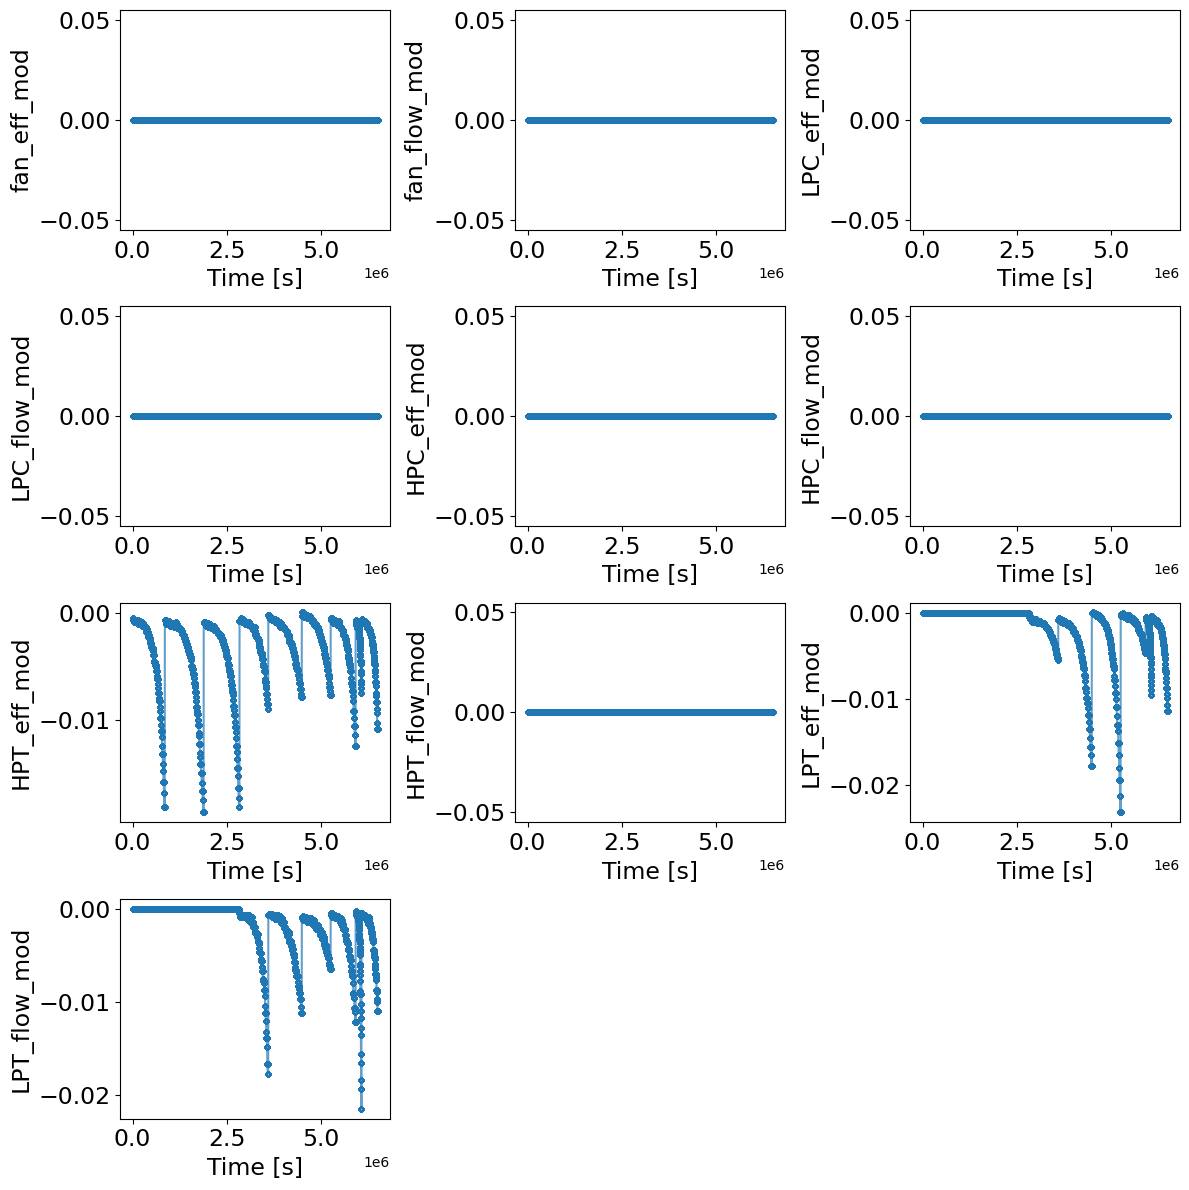

In [35]:
labels = T_var
plot_df_single_color(df_T, T_var , labels)

<Figure size 640x480 with 0 Axes>

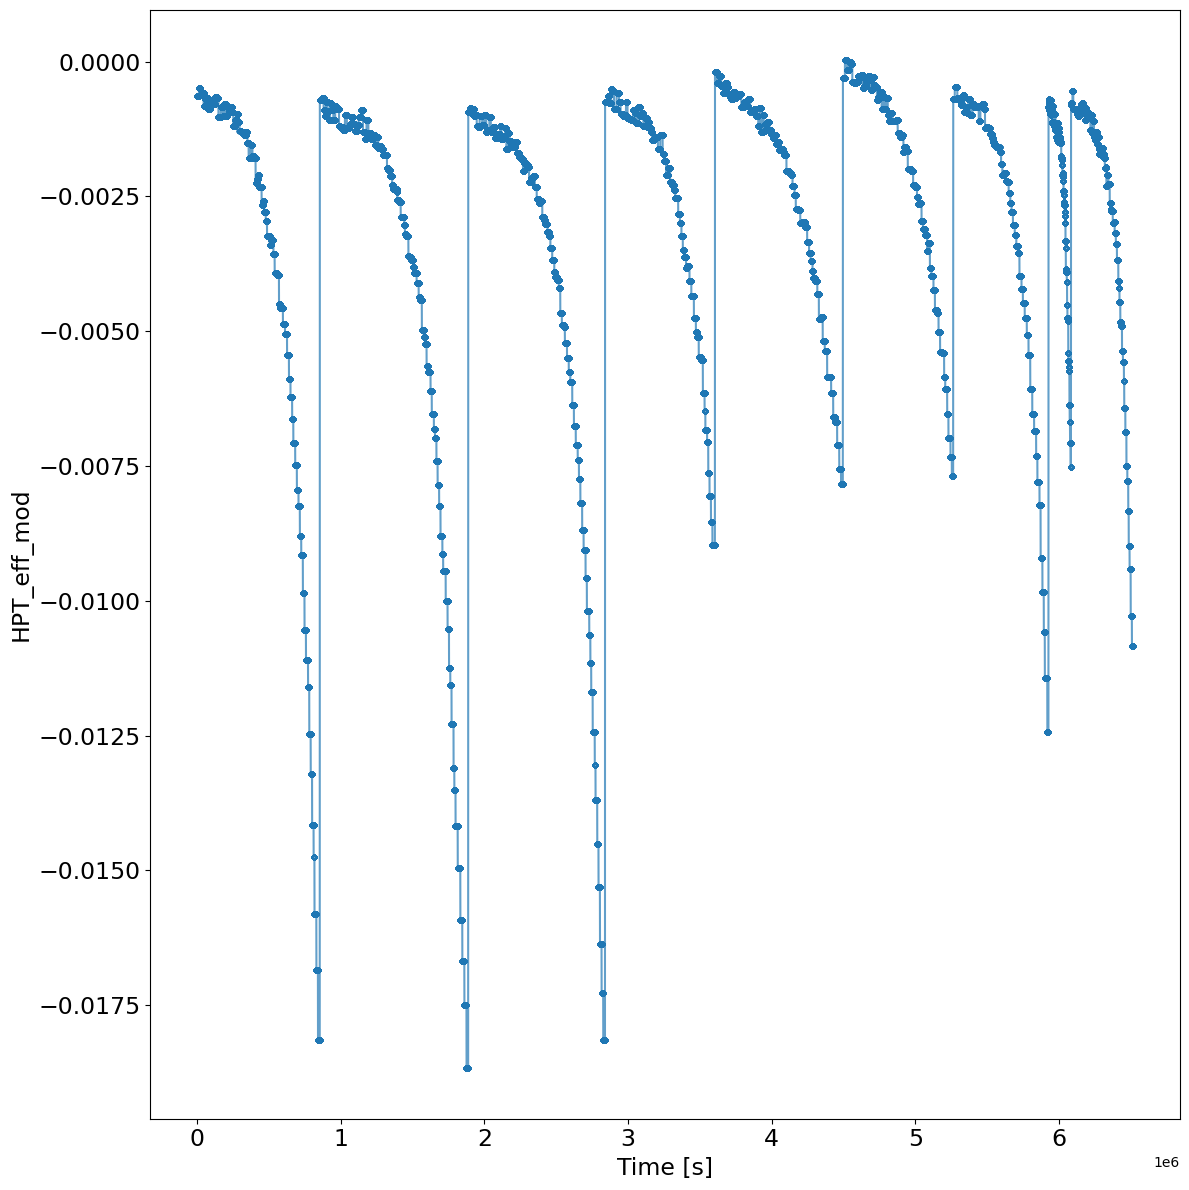

In [36]:
labels = ['HPT_eff_mod']  # Variable you want to plot

plot_df_single_color(df_T, labels, labels, size=12)

<Figure size 640x480 with 0 Axes>

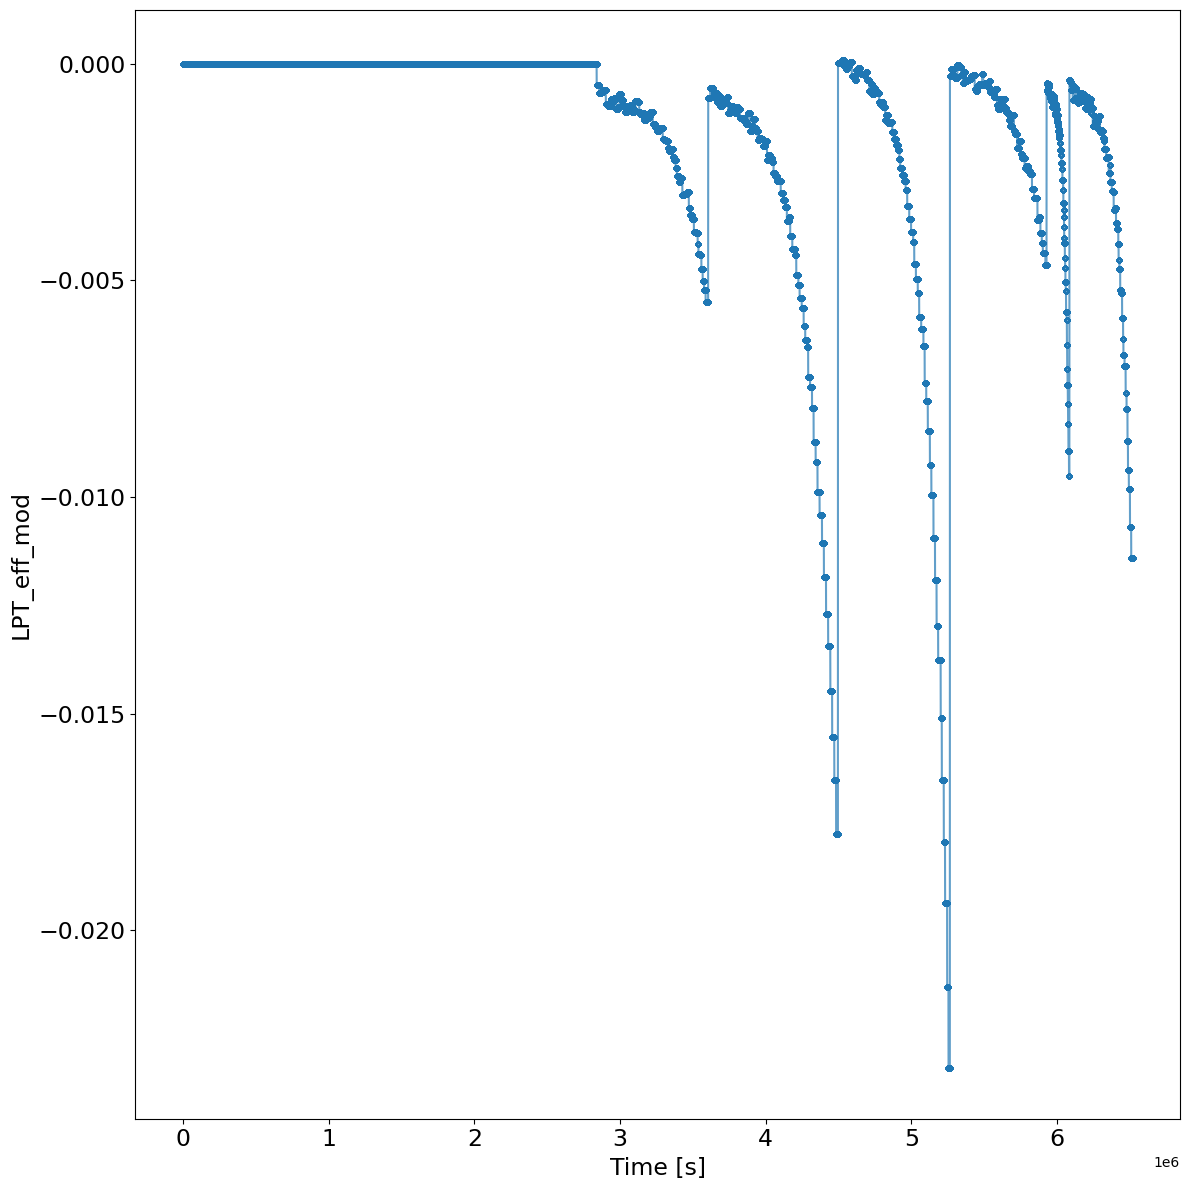

In [37]:
labels = ['LPT_eff_mod']  # Variable you want to plot

plot_df_single_color(df_T, labels, labels, size=12)

<Figure size 640x480 with 0 Axes>

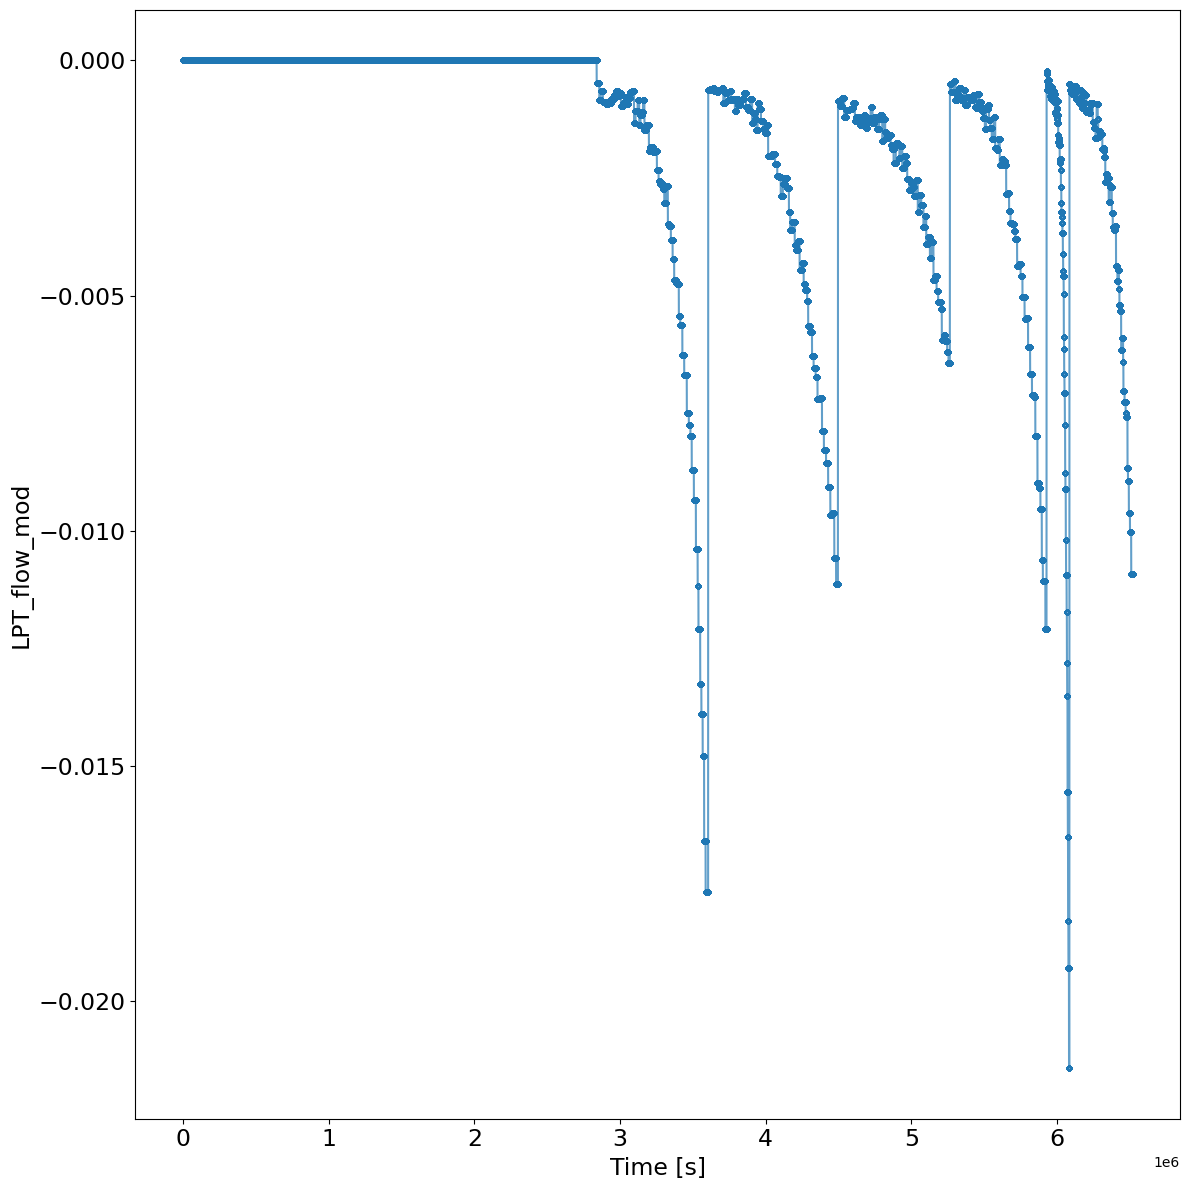

In [38]:
labels = ['LPT_flow_mod']  # Variable you want to plot

plot_df_single_color(df_T, labels, labels, size=12)

In [54]:
def plot_df_color_per_unit_one(data, variables, labels, size=7, labelsize=17, option='Time', name=None):
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim ** 0.5).astype(int), 4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs = gridspec.GridSpec(rows, cols)
    leg = []
    fig = plt.figure(figsize=(size, max(size, rows * 2)))
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'green'} 
    
    unit_sel = np.unique(data['unit'])

    y_min = data[variables].min().min()
    y_max = data[variables].max().max()

    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option == 'cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit ' + str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.set_ylim([y_min, y_max])  # Set Y-axis limits based on data
        ax.get_xaxis().set_major_formatter(
            ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

        # Customize y-axis label formatting to display negative values properly
        ax.get_yaxis().set_major_formatter(
            ticker.FuncFormatter(lambda x, p: f"{x:.3f}" if x != 0 else "0"))

    plt.legend(leg, loc='best', fontsize=labelsize-2)  # lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

<Figure size 640x480 with 0 Axes>

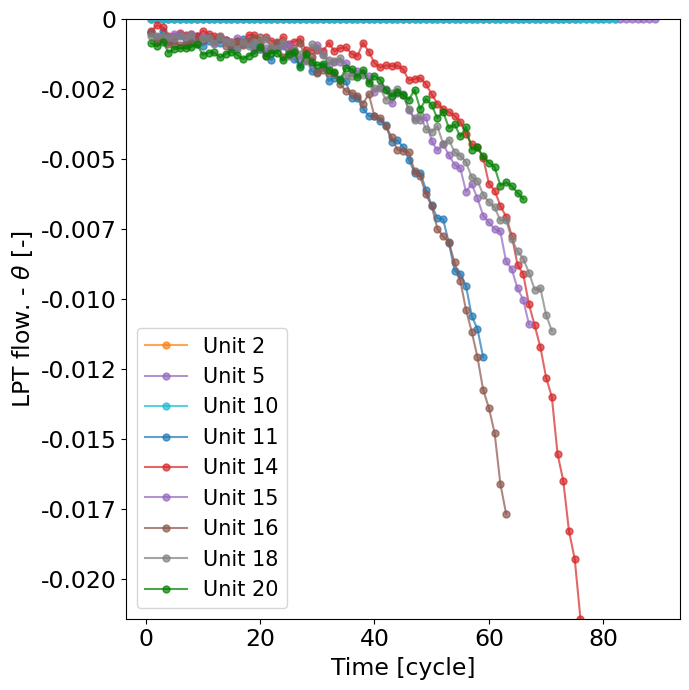

In [55]:
plot_df_color_per_unit_one(df_Ts, ['LPT_flow_mod'], [r'LPT flow. - $\theta$ [-]'], size=7,  option='cycle')

<Figure size 640x480 with 0 Axes>

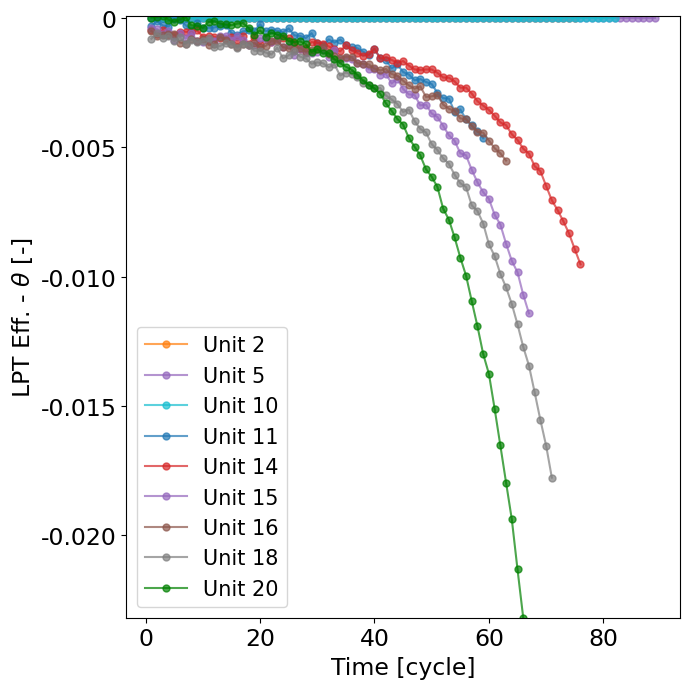

In [56]:
plot_df_color_per_unit_one(df_Ts, ['LPT_eff_mod'], [r'LPT Eff. - $\theta$ [-]'], size=7,  option='cycle')

<Figure size 640x480 with 0 Axes>

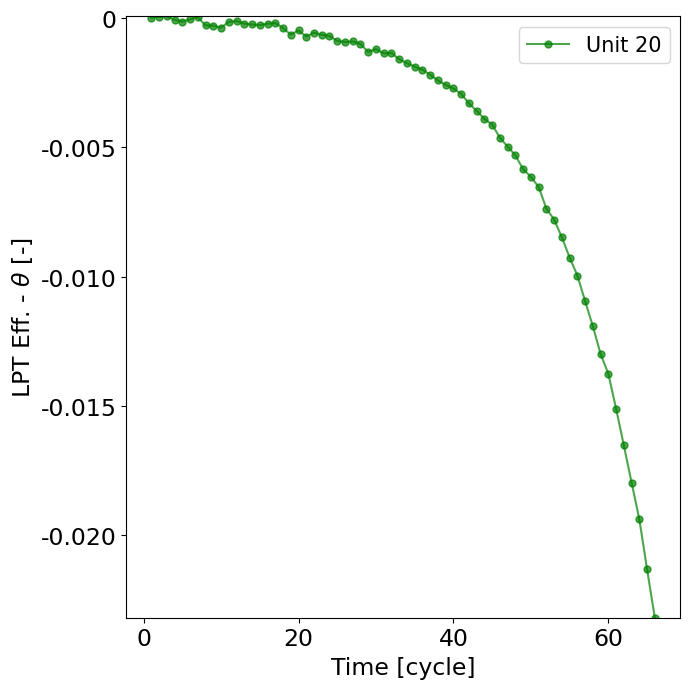

In [61]:

# Filter data for unit 10

df_ts_u = df_Ts.loc[df_Ts['unit'] == 20]
df_ts_u.reset_index(inplace=True, drop=True)
plot_df_color_per_unit_one(df_ts_u, ['LPT_eff_mod'], [r'LPT Eff. - $\theta$ [-]'], size=7,  option='cycle')

<Figure size 640x480 with 0 Axes>

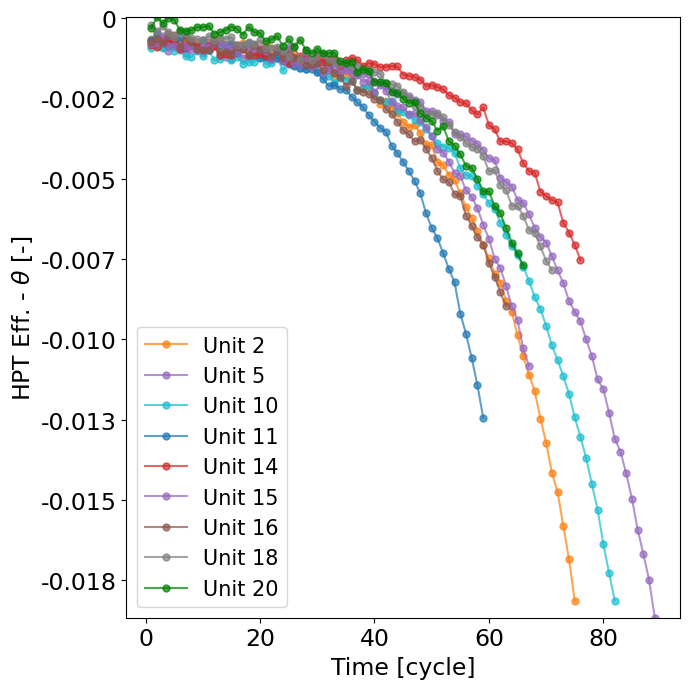

In [62]:
plot_df_color_per_unit_one(df_Ts, ['HPT_eff_mod'], [r'HPT Eff. - $\theta$ [-]'], size=7,  option='cycle')

In [11]:
df_X_s = DataFrame(data=X_s, columns=X_s_var) 

<Figure size 640x480 with 0 Axes>

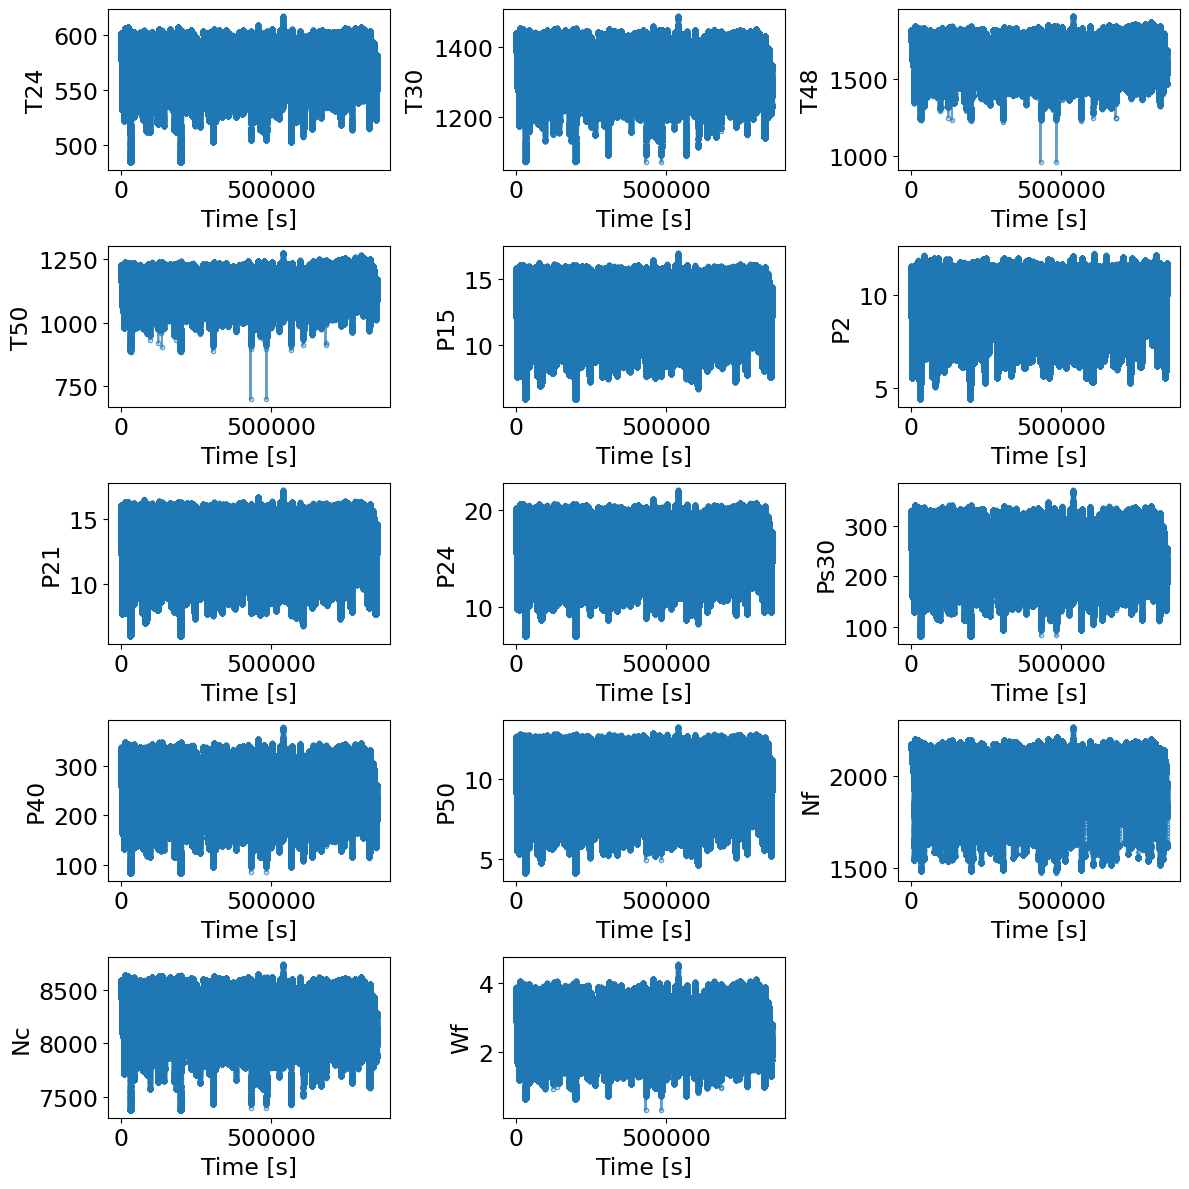

In [64]:
df_X_s_u = df_X_s.loc[df_A.unit == 2]
df_X_s_u.reset_index(inplace=True, drop=True)
labels = X_s_var
plot_df_single_color(df_X_s_u, X_s_var, labels)

<Figure size 640x480 with 0 Axes>

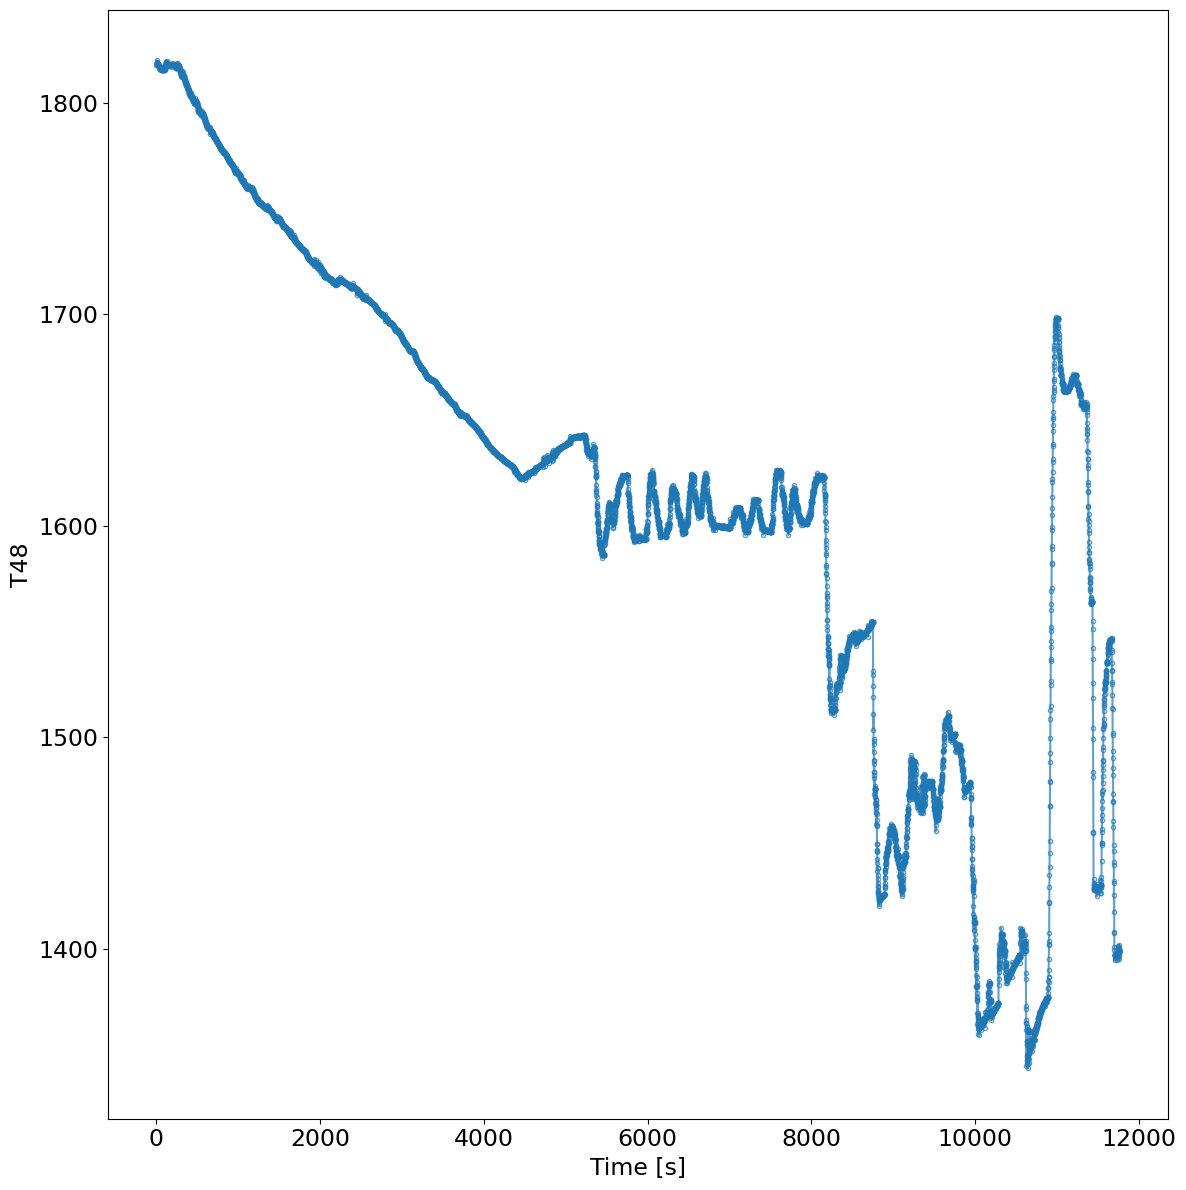

In [66]:
labels = ['T48']  # Variable you want to plot

df_X_s_u_c = df_X_s.loc[(df_A.unit == 2) & (df_A.cycle == 1)]
df_X_s_u_c.reset_index(inplace=True, drop=True)
plot_df_single_color(df_X_s_u_c, labels, labels)

<Figure size 640x480 with 0 Axes>

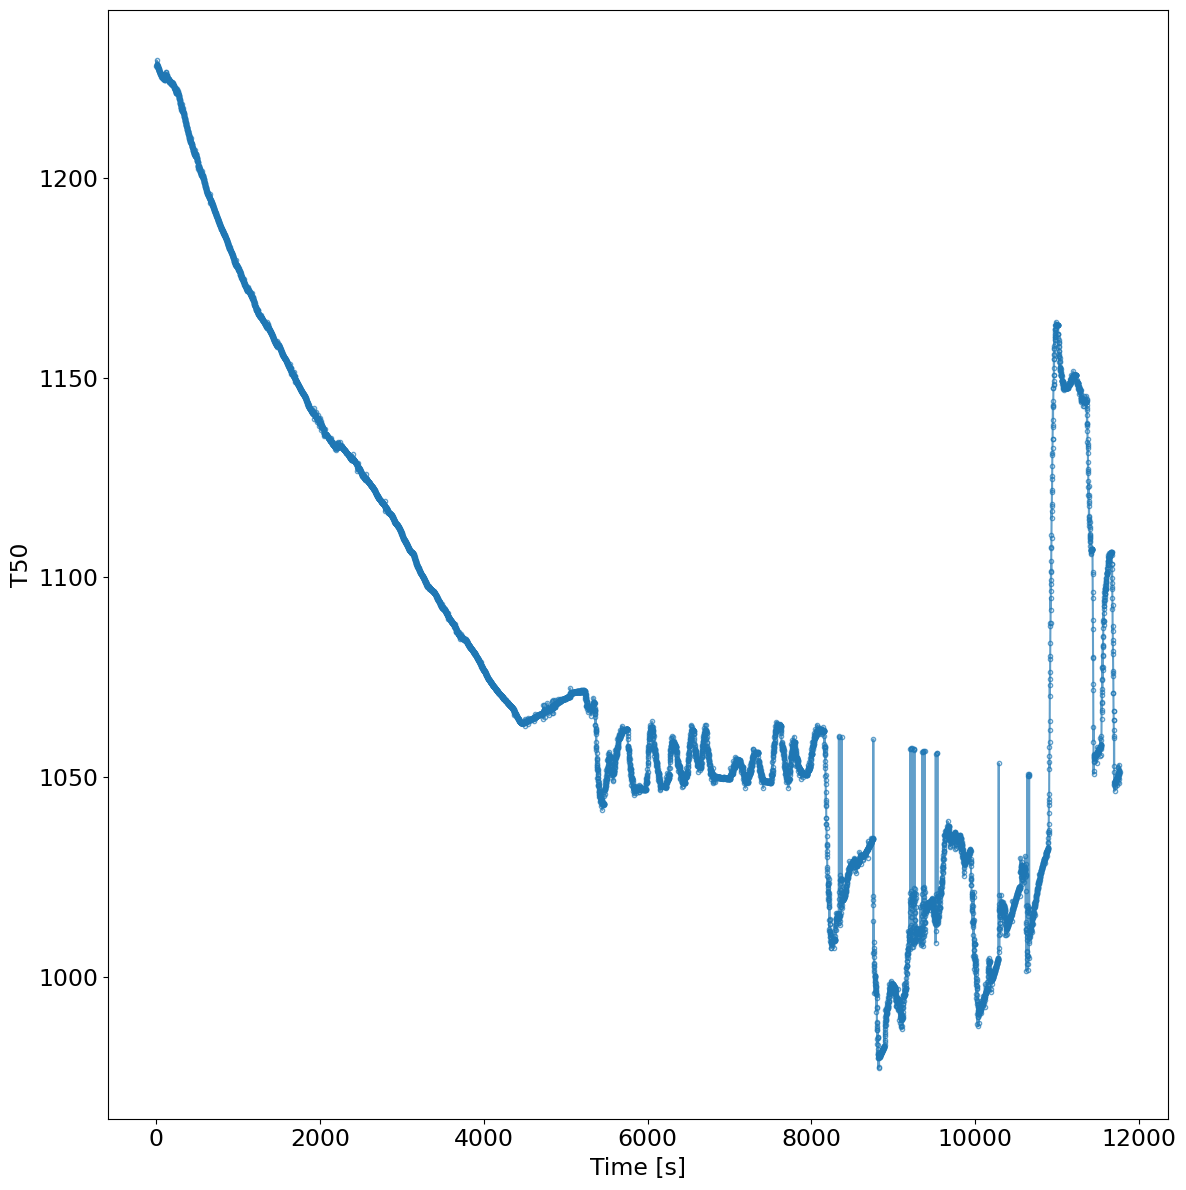

In [67]:
labels = ['T50']  # Variable you want to plot

df_X_s_u_c = df_X_s.loc[(df_A.unit == 2) & (df_A.cycle == 1)]
df_X_s_u_c.reset_index(inplace=True, drop=True)
plot_df_single_color(df_X_s_u_c, labels, labels)

<Figure size 640x480 with 0 Axes>

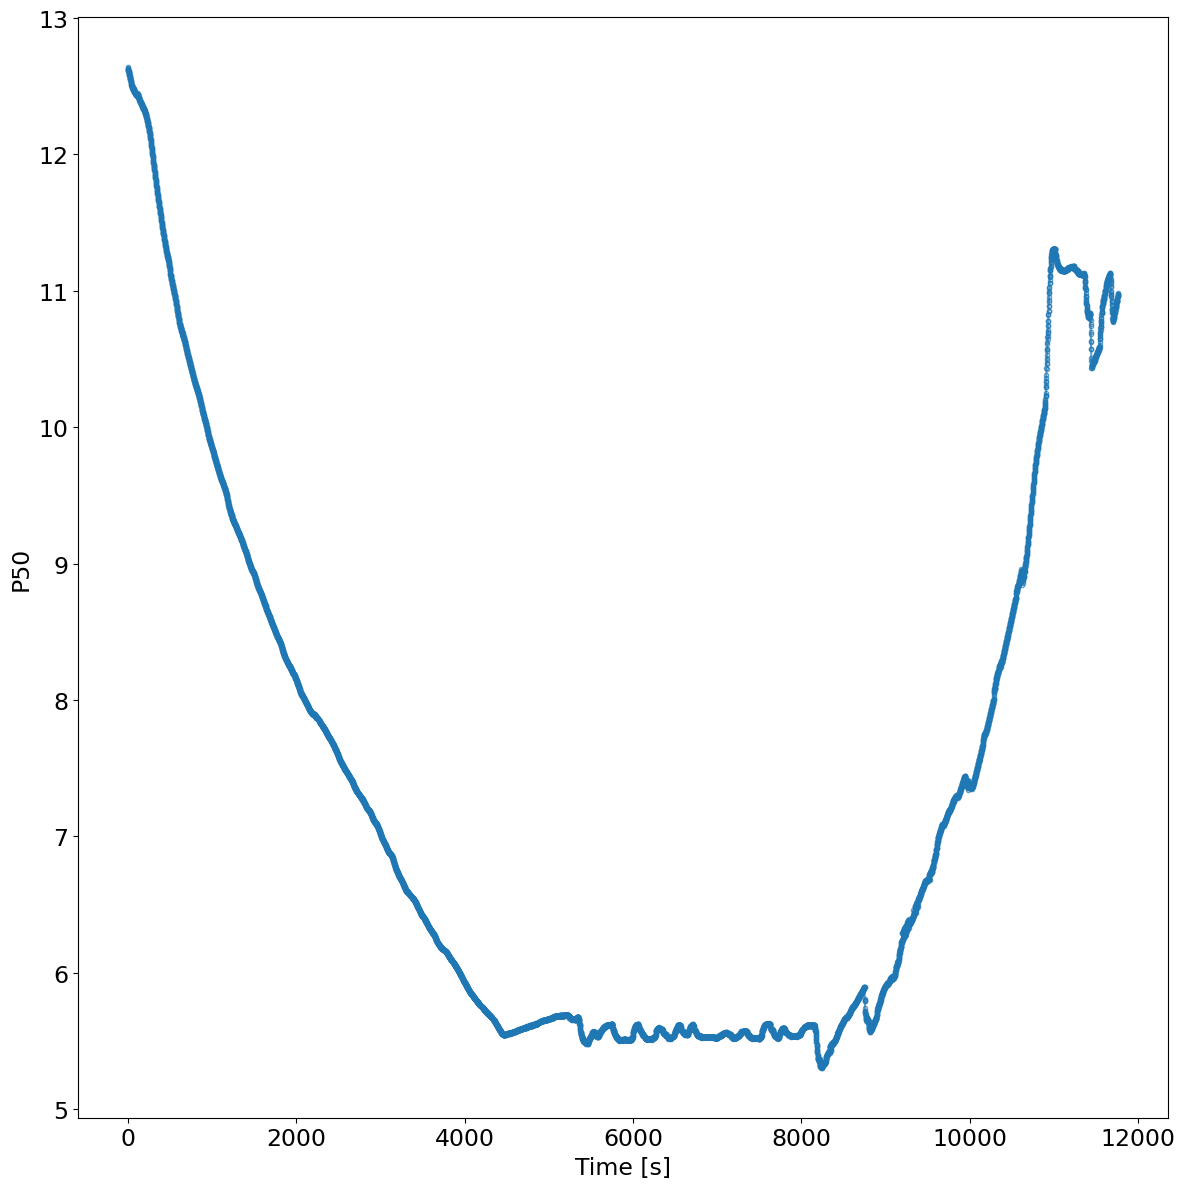

In [69]:
labels = ['P50']  # Variable you want to plot

df_X_s_u_c = df_X_s.loc[(df_A.unit == 2) & (df_A.cycle == 1)]
df_X_s_u_c.reset_index(inplace=True, drop=True)
plot_df_single_color(df_X_s_u_c, labels, labels)

In [74]:
# Calculate the Pearson correlation coefficient
# variables = ['alt', 'Mach', 'TRA', 'T2']
unit_A= 2
cycle_A=23
df_X_s_u_c = df_X_s.loc[(df_A.unit == unit_A) & (df_A.cycle == cycle_A)]
df_W_s_u_c = df_W.loc[(df_A.unit == unit_A) & (df_A.cycle == cycle_A)]

y = df_X_s_u_c['T48']
x = df_W_s_u_c['alt']
corr_coefficient, _ = pearsonr(x, y)

print(f"Pearson Correlation Coefficient: {corr_coefficient:.2f}")

Pearson Correlation Coefficient: 0.03


In [87]:
# Calculate the Pearson correlation coefficient
# variables = ['alt', 'Mach', 'TRA', 'T2']
unit_A= 2
cycle_A=23


y = df_X_s['T48']
x = df_W['alt']
corr_coefficient, _ = pearsonr(x, y)
y1 = df_X_s['T50']
x1 = df_W['alt']
corr_coefficient1, _ = pearsonr(x1, y1)

print(f"Pearson Correlation Coefficient Altitute vs T48: {corr_coefficient:.2f}")
print(f"Pearson Correlation Coefficient Altitute vs T50: {corr_coefficient1:.2f}")

Pearson Correlation Coefficient Altitute vs T48: -0.08
Pearson Correlation Coefficient Altitute vs T50: -0.53


In [106]:
# Define the variable pairs without 'alt'
variable_pairs = [('T48',), ('T50',), ('P50',), ('Wf',), ('Nf',), ('Nc',),
                  ('T24',), ('T30',), ('P15',), ('P21',), ('P24',), ('Ps30',), ('P40',)]

# Create an empty DataFrame to store correlation coefficients
corr_matrix = pd.DataFrame(index=[var_pair[0] for var_pair in variable_pairs], columns=['alt'])


# Calculate Pearson correlation coefficients for each variable pair
for var_pair in variable_pairs:
    var1 = 'alt'
    var2 = var_pair[0]
    corr_coefficient, _ = pearsonr(df_W[var1], df_X_s[var2])
    corr_matrix.at[var2, var1] = corr_coefficient
    print(f"Pearson Correlation Coefficient {var1} vs {var2}: {corr_coefficient:.2f}")

Pearson Correlation Coefficient alt vs T48: -0.08
Pearson Correlation Coefficient alt vs T50: -0.53
Pearson Correlation Coefficient alt vs P50: -0.98
Pearson Correlation Coefficient alt vs Wf: -0.58
Pearson Correlation Coefficient alt vs Nf: 0.29
Pearson Correlation Coefficient alt vs Nc: -0.28
Pearson Correlation Coefficient alt vs T24: -0.70
Pearson Correlation Coefficient alt vs T30: -0.31
Pearson Correlation Coefficient alt vs P15: -0.96
Pearson Correlation Coefficient alt vs P21: -0.96
Pearson Correlation Coefficient alt vs P24: -0.91
Pearson Correlation Coefficient alt vs Ps30: -0.70
Pearson Correlation Coefficient alt vs P40: -0.71


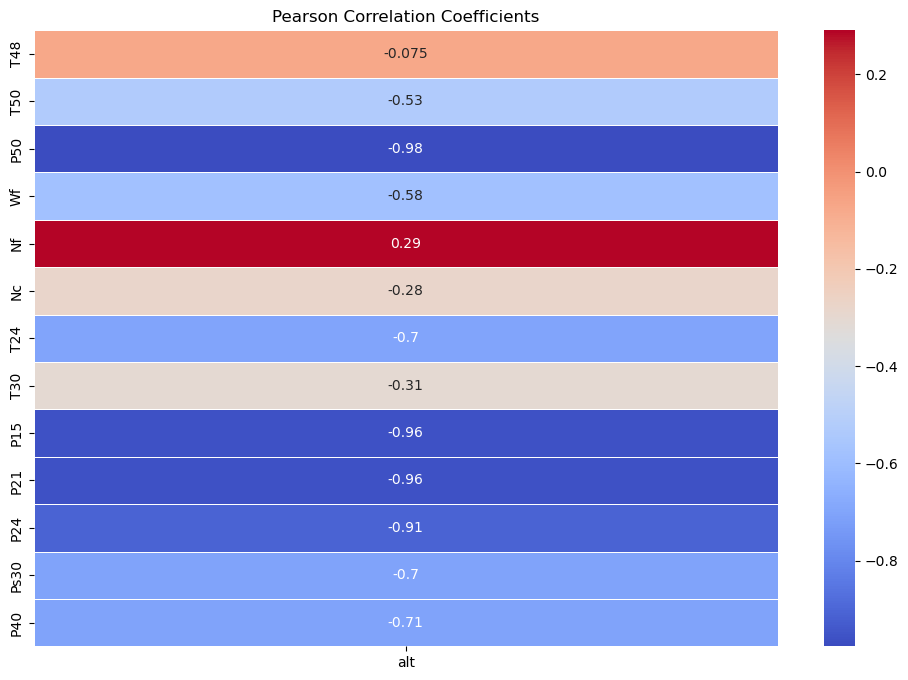

In [107]:
# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Pearson Correlation Coefficients")
plt.show()


In [110]:
# Define the variable pairs without 'alt'
variable_pairs = [('T48',), ('T50',), ('P50',), ('Wf',), ('Nf',), ('Nc',),
                  ('T24',), ('T30',), ('P15',), ('P21',), ('P24',), ('Ps30',), ('P40',)]

# Create an empty DataFrame to store correlation coefficients
corr_matrix = pd.DataFrame(index=[var_pair[0] for var_pair in variable_pairs], columns=['Mach'])


# Calculate Pearson correlation coefficients for each variable pair
for var_pair in variable_pairs:
    var1 = 'Mach'
    var2 = var_pair[0]
    corr_coefficient, _ = pearsonr(df_W[var1], df_X_s[var2])
    corr_matrix.at[var2, var1] = corr_coefficient
    print(f"Pearson Correlation Coefficient {var1} vs {var2}: {corr_coefficient:.2f}")

Pearson Correlation Coefficient Mach vs T48: -0.01
Pearson Correlation Coefficient Mach vs T50: -0.45
Pearson Correlation Coefficient Mach vs P50: -0.89
Pearson Correlation Coefficient Mach vs Wf: -0.48
Pearson Correlation Coefficient Mach vs Nf: 0.33
Pearson Correlation Coefficient Mach vs Nc: -0.18
Pearson Correlation Coefficient Mach vs T24: -0.54
Pearson Correlation Coefficient Mach vs T30: -0.20
Pearson Correlation Coefficient Mach vs P15: -0.84
Pearson Correlation Coefficient Mach vs P21: -0.84
Pearson Correlation Coefficient Mach vs P24: -0.78
Pearson Correlation Coefficient Mach vs Ps30: -0.59
Pearson Correlation Coefficient Mach vs P40: -0.60


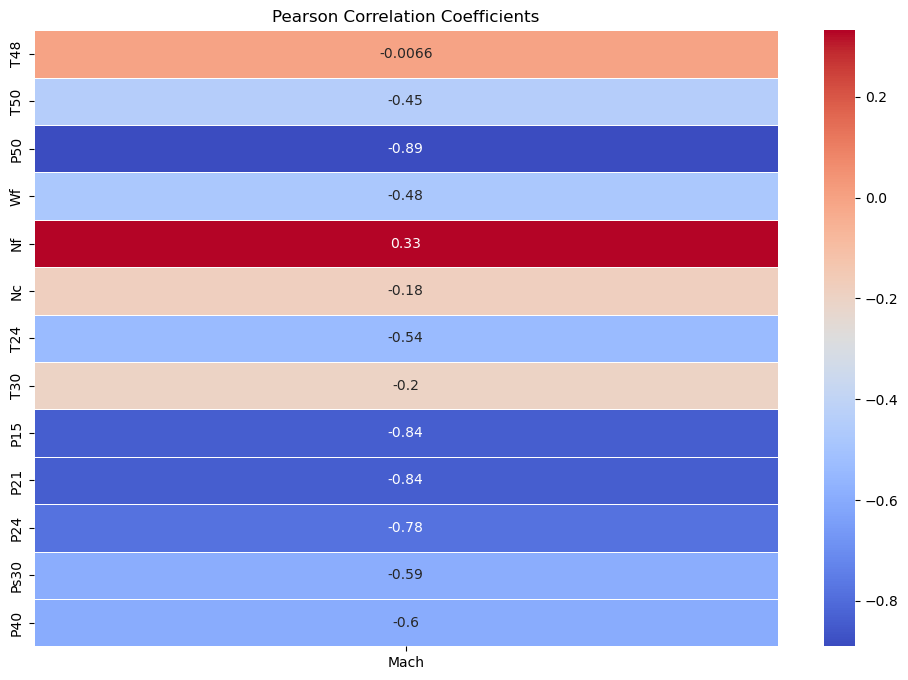

In [111]:
# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Pearson Correlation Coefficients")
plt.show()

In [112]:
# Define the variable pairs without 'alt'
variable_pairs = [('T48',), ('T50',), ('P50',), ('Wf',), ('Nf',), ('Nc',),
                  ('T24',), ('T30',), ('P15',), ('P21',), ('P24',), ('Ps30',), ('P40',)]

# Create an empty DataFrame to store correlation coefficients
corr_matrix = pd.DataFrame(index=[var_pair[0] for var_pair in variable_pairs], columns=['TRA'])


# Calculate Pearson correlation coefficients for each variable pair
for var_pair in variable_pairs:
    var1 = 'TRA'
    var2 = var_pair[0]
    corr_coefficient, _ = pearsonr(df_W[var1], df_X_s[var2])
    corr_matrix.at[var2, var1] = corr_coefficient
    print(f"Pearson Correlation Coefficient {var1} vs {var2}: {corr_coefficient:.2f}")

Pearson Correlation Coefficient TRA vs T48: 0.82
Pearson Correlation Coefficient TRA vs T50: 0.46
Pearson Correlation Coefficient TRA vs P50: -0.32
Pearson Correlation Coefficient TRA vs Wf: 0.40
Pearson Correlation Coefficient TRA vs Nf: 0.97
Pearson Correlation Coefficient TRA vs Nc: 0.68
Pearson Correlation Coefficient TRA vs T24: 0.24
Pearson Correlation Coefficient TRA vs T30: 0.66
Pearson Correlation Coefficient TRA vs P15: -0.27
Pearson Correlation Coefficient TRA vs P21: -0.27
Pearson Correlation Coefficient TRA vs P24: -0.12
Pearson Correlation Coefficient TRA vs Ps30: 0.25
Pearson Correlation Coefficient TRA vs P40: 0.24


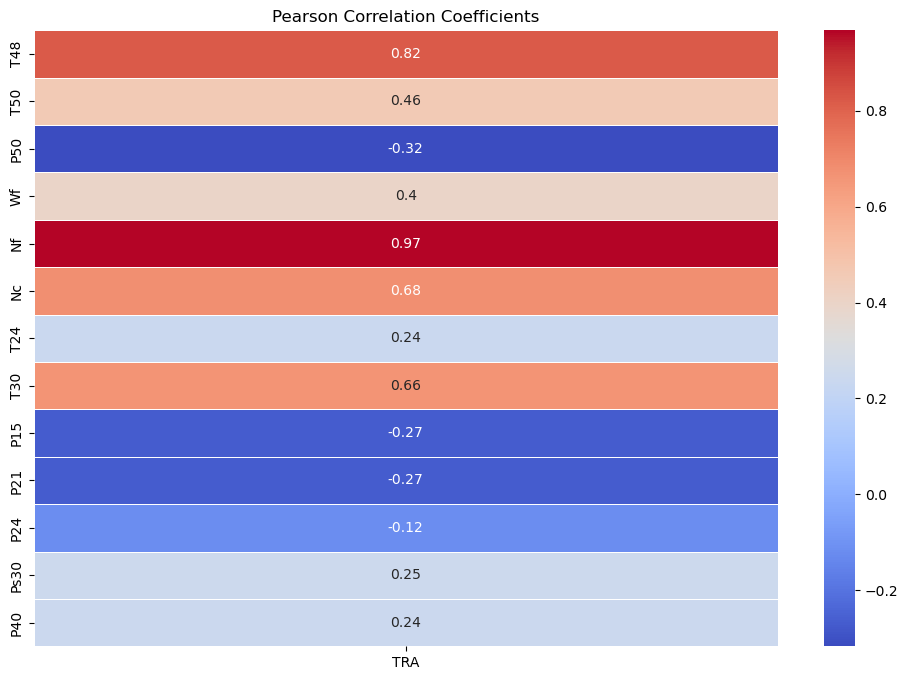

In [113]:
# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Pearson Correlation Coefficients")
plt.show()

In [115]:
# Define the variable pairs without 'alt'
variable_pairs = [('T48',), ('T50',), ('P50',), ('Wf',), ('Nf',), ('Nc',),
                  ('T24',), ('T30',), ('P15',), ('P21',), ('P24',), ('Ps30',), ('P40',)]

# Create an empty DataFrame to store correlation coefficients
corr_matrix = pd.DataFrame(index=[var_pair[0] for var_pair in variable_pairs], columns=['T2'])


# Calculate Pearson correlation coefficients for each variable pair
for var_pair in variable_pairs:
    var1 = 'T2'
    var2 = var_pair[0]
    corr_coefficient, _ = pearsonr(df_W[var1], df_X_s[var2])
    corr_matrix.at[var2, var1] = corr_coefficient
    print(f"Pearson Correlation Coefficient {var1} vs {var2}: {corr_coefficient:.2f}")

Pearson Correlation Coefficient T2 vs T48: 0.10
Pearson Correlation Coefficient T2 vs T50: 0.54
Pearson Correlation Coefficient T2 vs P50: 0.96
Pearson Correlation Coefficient T2 vs Wf: 0.60
Pearson Correlation Coefficient T2 vs Nf: -0.26
Pearson Correlation Coefficient T2 vs Nc: 0.31
Pearson Correlation Coefficient T2 vs T24: 0.74
Pearson Correlation Coefficient T2 vs T30: 0.34
Pearson Correlation Coefficient T2 vs P15: 0.97
Pearson Correlation Coefficient T2 vs P21: 0.97
Pearson Correlation Coefficient T2 vs P24: 0.92
Pearson Correlation Coefficient T2 vs Ps30: 0.72
Pearson Correlation Coefficient T2 vs P40: 0.72


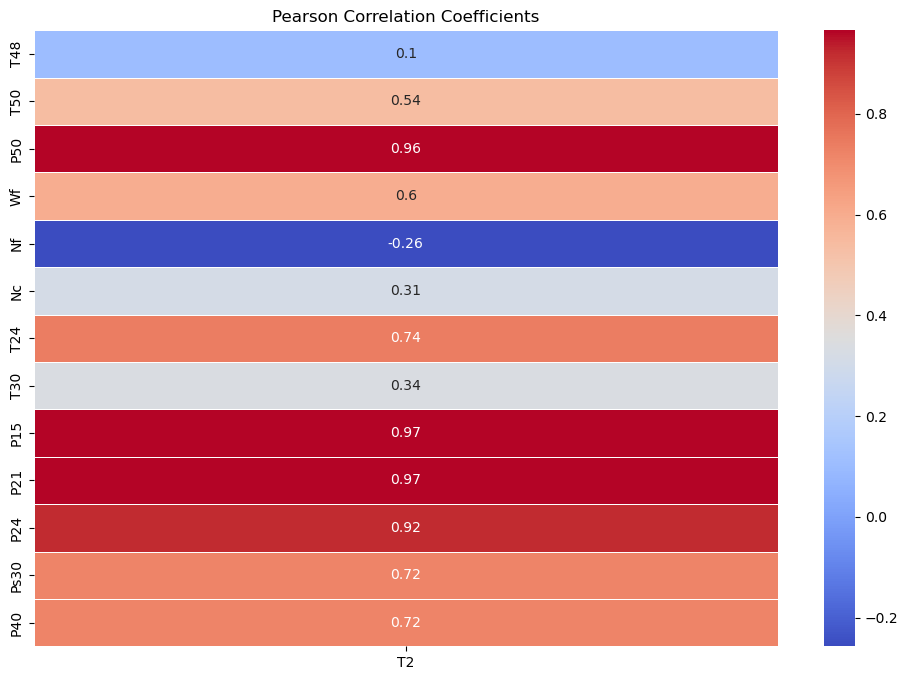

In [116]:
# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Pearson Correlation Coefficients")
plt.show()

In [119]:


# List of variable names to calculate correlations with 'HPT_eff_mod'
variables_to_correlate = ['T48', 'T50', 'P50', 'Wf', 'Nf', 'Nc', 'T24', 'T30', 'P15', 'P21', 'P24', 'Ps30', 'P40']

# Create an empty DataFrame to store correlation coefficients
corr_matrix = pd.DataFrame(index=variables_to_correlate, columns=['HPT_eff_mod'])

# Calculate Pearson correlation coefficients for each variable pair
for var2 in variables_to_correlate:
    var1 = 'HPT_eff_mod'
    corr_coefficient, _ = pearsonr(df_T[var1], df_X_s[var2])
    corr_matrix.at[var2, var1] = corr_coefficient
    print(f"Pearson Correlation Coefficient {var1} vs {var2}: {corr_coefficient:.2f}")


Pearson Correlation Coefficient HPT_eff_mod vs T48: -0.08
Pearson Correlation Coefficient HPT_eff_mod vs T50: -0.11
Pearson Correlation Coefficient HPT_eff_mod vs P50: 0.02
Pearson Correlation Coefficient HPT_eff_mod vs Wf: -0.00
Pearson Correlation Coefficient HPT_eff_mod vs Nf: 0.00
Pearson Correlation Coefficient HPT_eff_mod vs Nc: 0.04
Pearson Correlation Coefficient HPT_eff_mod vs T24: 0.01
Pearson Correlation Coefficient HPT_eff_mod vs T30: 0.02
Pearson Correlation Coefficient HPT_eff_mod vs P15: 0.02
Pearson Correlation Coefficient HPT_eff_mod vs P21: 0.02
Pearson Correlation Coefficient HPT_eff_mod vs P24: 0.02
Pearson Correlation Coefficient HPT_eff_mod vs Ps30: 0.02
Pearson Correlation Coefficient HPT_eff_mod vs P40: 0.03


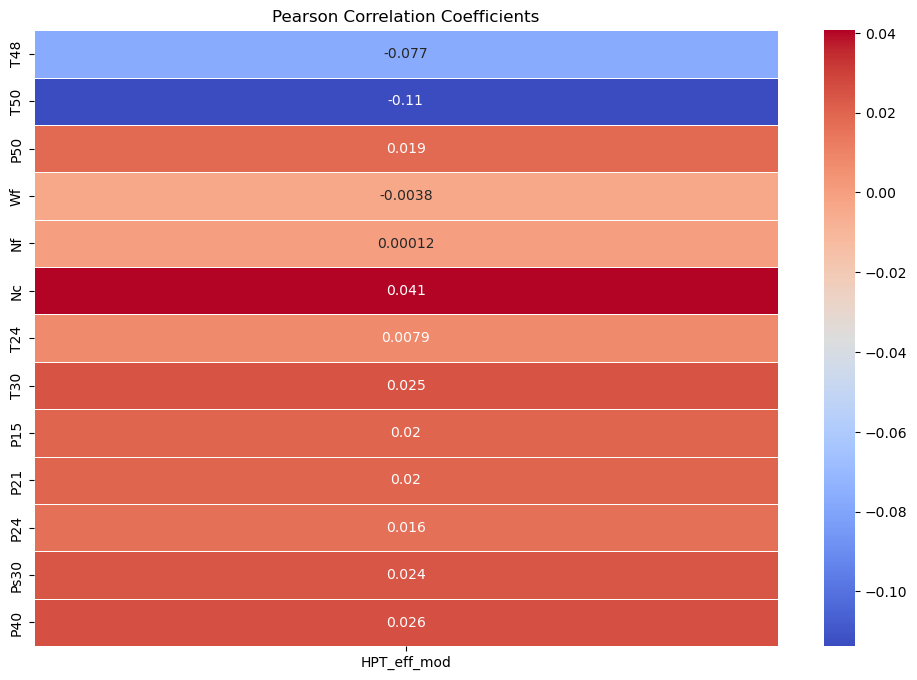

In [120]:
# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Pearson Correlation Coefficients")
plt.show()

In [121]:


# List of variable names to calculate correlations with 'HPT_eff_mod'
variables_to_correlate = ['T48', 'T50', 'P50', 'Wf', 'Nf', 'Nc', 'T24', 'T30', 'P15', 'P21', 'P24', 'Ps30', 'P40']

# Create an empty DataFrame to store correlation coefficients
corr_matrix = pd.DataFrame(index=variables_to_correlate, columns=['LPT_eff_mod'])

# Calculate Pearson correlation coefficients for each variable pair
for var2 in variables_to_correlate:
    var1 = 'LPT_eff_mod'
    corr_coefficient, _ = pearsonr(df_T[var1], df_X_s[var2])
    corr_matrix.at[var2, var1] = corr_coefficient
    print(f"Pearson Correlation Coefficient {var1} vs {var2}: {corr_coefficient:.2f}")


Pearson Correlation Coefficient LPT_eff_mod vs T48: -0.06
Pearson Correlation Coefficient LPT_eff_mod vs T50: -0.10
Pearson Correlation Coefficient LPT_eff_mod vs P50: 0.00
Pearson Correlation Coefficient LPT_eff_mod vs Wf: -0.02
Pearson Correlation Coefficient LPT_eff_mod vs Nf: -0.01
Pearson Correlation Coefficient LPT_eff_mod vs Nc: -0.01
Pearson Correlation Coefficient LPT_eff_mod vs T24: -0.01
Pearson Correlation Coefficient LPT_eff_mod vs T30: -0.01
Pearson Correlation Coefficient LPT_eff_mod vs P15: 0.00
Pearson Correlation Coefficient LPT_eff_mod vs P21: 0.00
Pearson Correlation Coefficient LPT_eff_mod vs P24: 0.00
Pearson Correlation Coefficient LPT_eff_mod vs Ps30: -0.01
Pearson Correlation Coefficient LPT_eff_mod vs P40: -0.00


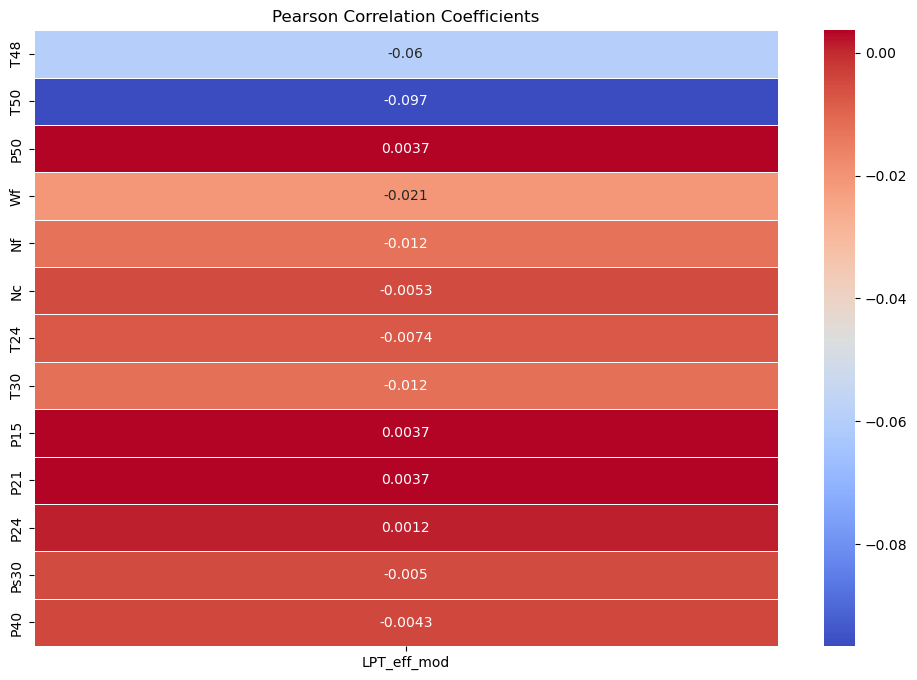

In [122]:
# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Pearson Correlation Coefficients")
plt.show()

In [123]:


# List of variable names to calculate correlations with 'HPT_eff_mod'
variables_to_correlate = ['T48', 'T50', 'P50', 'Wf', 'Nf', 'Nc', 'T24', 'T30', 'P15', 'P21', 'P24', 'Ps30', 'P40']

# Create an empty DataFrame to store correlation coefficients
corr_matrix = pd.DataFrame(index=variables_to_correlate, columns=['LPT_flow_mod'])

# Calculate Pearson correlation coefficients for each variable pair
for var2 in variables_to_correlate:
    var1 = 'LPT_flow_mod'
    corr_coefficient, _ = pearsonr(df_T[var1], df_X_s[var2])
    corr_matrix.at[var2, var1] = corr_coefficient
    print(f"Pearson Correlation Coefficient {var1} vs {var2}: {corr_coefficient:.2f}")


Pearson Correlation Coefficient LPT_flow_mod vs T48: -0.06
Pearson Correlation Coefficient LPT_flow_mod vs T50: -0.10
Pearson Correlation Coefficient LPT_flow_mod vs P50: -0.03
Pearson Correlation Coefficient LPT_flow_mod vs Wf: -0.03
Pearson Correlation Coefficient LPT_flow_mod vs Nf: 0.00
Pearson Correlation Coefficient LPT_flow_mod vs Nc: 0.01
Pearson Correlation Coefficient LPT_flow_mod vs T24: -0.02
Pearson Correlation Coefficient LPT_flow_mod vs T30: -0.00
Pearson Correlation Coefficient LPT_flow_mod vs P15: -0.03
Pearson Correlation Coefficient LPT_flow_mod vs P21: -0.03
Pearson Correlation Coefficient LPT_flow_mod vs P24: -0.03
Pearson Correlation Coefficient LPT_flow_mod vs Ps30: -0.02
Pearson Correlation Coefficient LPT_flow_mod vs P40: -0.02


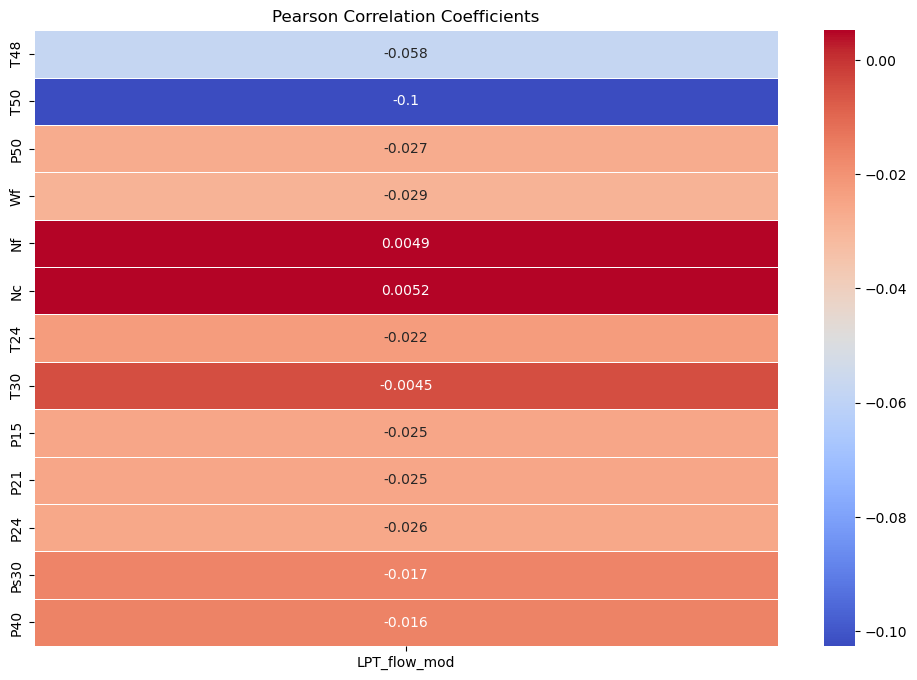

In [124]:
# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Pearson Correlation Coefficients")
plt.show()

In [129]:

# List of variable names to calculate correlations with 'HPT_eff_mod'
variables_to_correlate = ['T48', 'T50', 'P50', 'Wf', 'Nf', 'Nc', 'T24', 'T30', 'P15', 'P21', 'P24', 'Ps30', 'P40']

# Create an empty DataFrame to store correlation coefficients
corr_matrix = pd.DataFrame(index=variables_to_correlate, columns=['LPT_flow_mod'])

# Loop through variable pairs
for var2 in variables_to_correlate:
    var1 = 'LPT_flow_mod'
    corr_coefficient, p_value = spearmanr(df_T[var1], df_X_s[var2])
    corr_matrix.at[var2, var1] = corr_coefficient
    
    # Print correlation coefficient and p-value
    print(f"Spearman Correlation Coefficient {var1} vs {var2}: {corr_coefficient:.2f}")
    print(f"P-value: {p_value:.4f}")
    
    # Interpret the results
    if p_value < 0.05:
        print("There is a statistically significant correlation.")
    else:
        print("There is no statistically significant correlation.")


Spearman Correlation Coefficient LPT_flow_mod vs T48: -0.05
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient LPT_flow_mod vs T50: -0.09
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient LPT_flow_mod vs P50: -0.04
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient LPT_flow_mod vs Wf: -0.04
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient LPT_flow_mod vs Nf: 0.01
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient LPT_flow_mod vs Nc: -0.02
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient LPT_flow_mod vs T24: -0.04
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient LPT_flow_mod vs T30: -0.02
P-value: 0.0000
There is a statistically significant correlati

In [128]:
# List of variable names to calculate correlations with 'HPT_eff_mod'
variables_to_correlate = ['T48', 'T50', 'P50', 'Wf', 'Nf', 'Nc', 'T24', 'T30', 'P15', 'P21', 'P24', 'Ps30', 'P40']

# Create an empty DataFrame to store correlation coefficients
corr_matrix = pd.DataFrame(index=variables_to_correlate, columns=['LPT_eff_mod'])

# Loop through variable pairs
for var2 in variables_to_correlate:
    var1 = 'LPT_eff_mod'
    corr_coefficient, p_value = spearmanr(df_T[var1], df_X_s[var2])
    corr_matrix.at[var2, var1] = corr_coefficient
    
    # Print correlation coefficient and p-value
    print(f"Spearman Correlation Coefficient {var1} vs {var2}: {corr_coefficient:.2f}")
    print(f"P-value: {p_value:.4f}")
    
    # Interpret the results
    if p_value < 0.05:
        print("There is a statistically significant correlation.")
    else:
        print("There is no statistically significant correlation.")

Spearman Correlation Coefficient LPT_eff_mod vs T48: -0.05
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient LPT_eff_mod vs T50: -0.09
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient LPT_eff_mod vs P50: -0.04
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient LPT_eff_mod vs Wf: -0.04
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient LPT_eff_mod vs Nf: 0.00
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient LPT_eff_mod vs Nc: -0.02
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient LPT_eff_mod vs T24: -0.04
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient LPT_eff_mod vs T30: -0.02
P-value: 0.0000
There is a statistically significant correlation.
Spea

In [130]:
# List of variable names to calculate correlations with 'HPT_eff_mod'
variables_to_correlate = ['T48', 'T50', 'P50', 'Wf', 'Nf', 'Nc', 'T24', 'T30', 'P15', 'P21', 'P24', 'Ps30', 'P40']

# Create an empty DataFrame to store correlation coefficients
corr_matrix = pd.DataFrame(index=variables_to_correlate, columns=['HPT_eff_mod'])

# Loop through variable pairs
for var2 in variables_to_correlate:
    var1 = 'HPT_eff_mod'
    corr_coefficient, p_value = spearmanr(df_T[var1], df_X_s[var2])
    corr_matrix.at[var2, var1] = corr_coefficient
    
    # Print correlation coefficient and p-value
    print(f"Spearman Correlation Coefficient {var1} vs {var2}: {corr_coefficient:.2f}")
    print(f"P-value: {p_value:.4f}")
    
    # Interpret the results
    if p_value < 0.05:
        print("There is a statistically significant correlation.")
    else:
        print("There is no statistically significant correlation.")

Spearman Correlation Coefficient HPT_eff_mod vs T48: -0.09
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient HPT_eff_mod vs T50: -0.12
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient HPT_eff_mod vs P50: 0.01
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient HPT_eff_mod vs Wf: -0.01
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient HPT_eff_mod vs Nf: -0.00
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient HPT_eff_mod vs Nc: 0.03
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient HPT_eff_mod vs T24: -0.00
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient HPT_eff_mod vs T30: 0.01
P-value: 0.0000
There is a statistically significant correlation.
Spearm

In [ ]:
"""
The correlation coefficient indicates the strength and direction of the 
relationship between the variables. If it's positive, it suggests that as
 one variable increases, the other tends to increase as well. If it's negative,
   it suggests that as one variable increases, the other tends to decrease.

The p-value associated with the correlation coefficient measures the 
probability that the observed correlation could have occurred due to random
sampling. A small p-value (typically less than a chosen significance level,
often 0.05) indicates that the correlation is statistically significant
because the likelihood of obtaining such a correlation by chance is 
very low.

So, when you see "There is a statistically significant correlation,"
 it means that the relationship between the two variables you're analyzing 
 is unlikely to be a result of random noise or chance. Instead, it suggests 
 that there is a meaningful and statistically supported association between 
 those variables.






"""

In [12]:
# List of variable names to calculate correlations with 'HPT_eff_mod'
variables_to_correlate = ['T48', 'T50', 'P50', 'Wf', 'Nf', 'Nc', 'T24', 'T30', 'P15', 'P21', 'P24', 'Ps30', 'P40']

# Create an empty DataFrame to store correlation coefficients
corr_matrix = pd.DataFrame(index=variables_to_correlate, columns=['alt'])

# Loop through variable pairs
for var2 in variables_to_correlate:
    var1 = 'alt'
    corr_coefficient, p_value = spearmanr(df_W[var1], df_X_s[var2])
    corr_matrix.at[var2, var1] = corr_coefficient
    
    # Print correlation coefficient and p-value
    print(f"Spearman Correlation Coefficient {var1} vs {var2}: {corr_coefficient:.2f}")
    print(f"P-value: {p_value:.4f}")
    
    # Interpret the results
    if p_value < 0.05:
        print("There is a statistically significant correlation.")
    else:
        print("There is no statistically significant correlation.")

Spearman Correlation Coefficient alt vs T48: -0.12
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient alt vs T50: -0.51
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient alt vs P50: -0.98
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient alt vs Wf: -0.56
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient alt vs Nf: 0.17
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient alt vs Nc: -0.32
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient alt vs T24: -0.70
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient alt vs T30: -0.33
P-value: 0.0000
There is a statistically significant correlation.
Spearman Correlation Coefficient alt vs P15: -0.97
P-value: 0.0000
T

Pearson Correlation Coefficient alt vs T48: -0.08
Pearson Correlation Coefficient alt vs T50: -0.53
Pearson Correlation Coefficient alt vs P50: -0.98
Pearson Correlation Coefficient alt vs Wf: -0.58
Pearson Correlation Coefficient alt vs Nf: 0.29
Pearson Correlation Coefficient alt vs Nc: -0.28
Pearson Correlation Coefficient alt vs T24: -0.70
Pearson Correlation Coefficient alt vs T30: -0.31
Pearson Correlation Coefficient alt vs P15: -0.96
Pearson Correlation Coefficient alt vs P21: -0.96
Pearson Correlation Coefficient alt vs P24: -0.91
Pearson Correlation Coefficient alt vs Ps30: -0.70
Pearson Correlation Coefficient alt vs P40: -0.71

Text(0, 0.5, 'Flight Class # [-]')

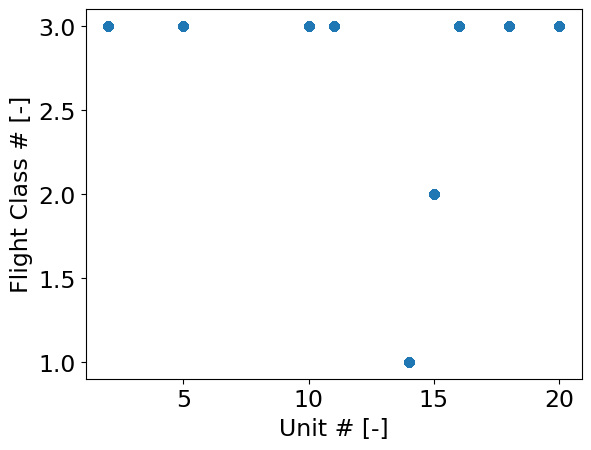

In [13]:
labelsize = 17
plt.plot(df_A.unit, df_A.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

In [14]:

data_to_display = df_A[['unit', 'Fc']]

# Create a DataFrame
table_df = pd.DataFrame(data_to_display)

# Display the DataFrame as a table
print(table_df)

         unit   Fc
0         2.0  3.0
1         2.0  3.0
2         2.0  3.0
3         2.0  3.0
4         2.0  3.0
...       ...  ...
6517185  15.0  2.0
6517186  15.0  2.0
6517187  15.0  2.0
6517188  15.0  2.0
6517189  15.0  2.0

[6517190 rows x 2 columns]


In [20]:
for i in np.unique(df_A['Fc']):
    print('Flight Class: ' + str(i) + ' - Number of flight Cycles: ', len(np.unique(df_A.loc[df_A['Fc'] == i, 'cycle'])))

Flight Class: 1.0 - Number of flight Cycles:  76
Flight Class: 2.0 - Number of flight Cycles:  67
Flight Class: 3.0 - Number of flight Cycles:  89


In [21]:
# Specify the flight classes you want to count
flight_classes = [1, 2, 3]

# Loop through the specified flight classes
for i in flight_classes:
    num_cycles = len(np.unique(df_A.loc[df_A['Fc'] == i, 'cycle']))
    print(f'Flight Class: {i} - Number of Flight Cycles: {num_cycles}')

Flight Class: 1 - Number of Flight Cycles: 76
Flight Class: 2 - Number of Flight Cycles: 67
Flight Class: 3 - Number of Flight Cycles: 89


In [78]:
for unit in np.unique(df_A['unit']):
    unit_df = df_A[df_A['unit'] == unit]
    y = df_X_s.loc[unit_df.index, 'T48']  # Extract the corresponding 'T48' values
    x = df_W.loc[unit_df.index, 'alt']    # Extract the corresponding 'alt' values

    corr_coefficient, _ = pearsonr(x, y)

    print(f"Unit {unit}: Pearson Correlation Coefficient T48 vs Altitude: {corr_coefficient:.2f}")

Unit 2.0: Pearson Correlation Coefficient T48 vs Altitude: -0.10
Unit 5.0: Pearson Correlation Coefficient T48 vs Altitude: -0.06
Unit 10.0: Pearson Correlation Coefficient T48 vs Altitude: -0.07
Unit 11.0: Pearson Correlation Coefficient T48 vs Altitude: -0.04
Unit 14.0: Pearson Correlation Coefficient T48 vs Altitude: -0.06
Unit 15.0: Pearson Correlation Coefficient T48 vs Altitude: -0.03
Unit 16.0: Pearson Correlation Coefficient T48 vs Altitude: -0.08
Unit 18.0: Pearson Correlation Coefficient T48 vs Altitude: -0.10
Unit 20.0: Pearson Correlation Coefficient T48 vs Altitude: -0.04


In [79]:
for unit in np.unique(df_A['unit']):
    unit_df = df_A[df_A['unit'] == unit]
    y = df_X_s.loc[unit_df.index, 'T50']  # Extract the corresponding 'T48' values
    x = df_W.loc[unit_df.index, 'alt']    # Extract the corresponding 'alt' values

    corr_coefficient, _ = pearsonr(x, y)

    print(f"Unit {unit}: Pearson Correlation Coefficient T50 vs Altitude: {corr_coefficient:.2f}")

Unit 2.0: Pearson Correlation Coefficient T50 vs Altitude: -0.53
Unit 5.0: Pearson Correlation Coefficient T50 vs Altitude: -0.53
Unit 10.0: Pearson Correlation Coefficient T50 vs Altitude: -0.52
Unit 11.0: Pearson Correlation Coefficient T50 vs Altitude: -0.50
Unit 14.0: Pearson Correlation Coefficient T50 vs Altitude: -0.24
Unit 15.0: Pearson Correlation Coefficient T50 vs Altitude: -0.38
Unit 16.0: Pearson Correlation Coefficient T50 vs Altitude: -0.55
Unit 18.0: Pearson Correlation Coefficient T50 vs Altitude: -0.54
Unit 20.0: Pearson Correlation Coefficient T50 vs Altitude: -0.49


In [80]:
for unit in np.unique(df_A['unit']):
    unit_df = df_A[df_A['unit'] == unit]
    y = df_X_s.loc[unit_df.index, 'P50']  # Extract the corresponding 'T48' values
    x = df_W.loc[unit_df.index, 'alt']    # Extract the corresponding 'alt' values

    corr_coefficient, _ = pearsonr(x, y)

    print(f"Unit {unit}: Pearson Correlation Coefficient P50 vs Altitude: {corr_coefficient:.2f}")

Unit 2.0: Pearson Correlation Coefficient P50 vs Altitude: -0.97
Unit 5.0: Pearson Correlation Coefficient P50 vs Altitude: -0.98
Unit 10.0: Pearson Correlation Coefficient P50 vs Altitude: -0.97
Unit 11.0: Pearson Correlation Coefficient P50 vs Altitude: -0.97
Unit 14.0: Pearson Correlation Coefficient P50 vs Altitude: -0.86
Unit 15.0: Pearson Correlation Coefficient P50 vs Altitude: -0.96
Unit 16.0: Pearson Correlation Coefficient P50 vs Altitude: -0.98
Unit 18.0: Pearson Correlation Coefficient P50 vs Altitude: -0.98
Unit 20.0: Pearson Correlation Coefficient P50 vs Altitude: -0.97


In [82]:
for unit in np.unique(df_A['unit']):
    unit_df = df_A[df_A['unit'] == unit]
    y = df_X_s.loc[unit_df.index, 'T48']  # Extract the corresponding 'T48' values
    x = df_W.loc[unit_df.index, 'Mach']    # Extract the corresponding 'alt' values

    corr_coefficient, _ = pearsonr(x, y)

    print(f"Unit {unit}: Pearson Correlation Coefficient T48 vs Mach Number: {corr_coefficient:.2f}")

Unit 2.0: Pearson Correlation Coefficient T48 vs Mach Number: -0.04
Unit 5.0: Pearson Correlation Coefficient T48 vs Mach Number: -0.03
Unit 10.0: Pearson Correlation Coefficient T48 vs Mach Number: 0.01
Unit 11.0: Pearson Correlation Coefficient T48 vs Mach Number: 0.02
Unit 14.0: Pearson Correlation Coefficient T48 vs Mach Number: 0.25
Unit 15.0: Pearson Correlation Coefficient T48 vs Mach Number: 0.03
Unit 16.0: Pearson Correlation Coefficient T48 vs Mach Number: -0.01
Unit 18.0: Pearson Correlation Coefficient T48 vs Mach Number: -0.03
Unit 20.0: Pearson Correlation Coefficient T48 vs Mach Number: 0.06


In [83]:
for unit in np.unique(df_A['unit']):
    unit_df = df_A[df_A['unit'] == unit]
    y = df_X_s.loc[unit_df.index, 'T50']  # Extract the corresponding 'T48' values
    x = df_W.loc[unit_df.index, 'Mach']    # Extract the corresponding 'alt' values

    corr_coefficient, _ = pearsonr(x, y)

    print(f"Unit {unit}: Pearson Correlation Coefficient T50 vs Mach Number: {corr_coefficient:.2f}")

Unit 2.0: Pearson Correlation Coefficient T50 vs Mach Number: -0.45
Unit 5.0: Pearson Correlation Coefficient T50 vs Mach Number: -0.49
Unit 10.0: Pearson Correlation Coefficient T50 vs Mach Number: -0.44
Unit 11.0: Pearson Correlation Coefficient T50 vs Mach Number: -0.42
Unit 14.0: Pearson Correlation Coefficient T50 vs Mach Number: 0.12
Unit 15.0: Pearson Correlation Coefficient T50 vs Mach Number: -0.30
Unit 16.0: Pearson Correlation Coefficient T50 vs Mach Number: -0.45
Unit 18.0: Pearson Correlation Coefficient T50 vs Mach Number: -0.46
Unit 20.0: Pearson Correlation Coefficient T50 vs Mach Number: -0.36


In [85]:
for unit in np.unique(df_A['unit']):
    unit_df = df_A[df_A['unit'] == unit]
    y = df_X_s.loc[unit_df.index, 'P50']  # Extract the corresponding 'T48' values
    x = df_W.loc[unit_df.index, 'Mach']    # Extract the corresponding 'alt' values

    corr_coefficient, _ = pearsonr(x, y)

    print(f"Unit {unit}: Pearson Correlation Coefficient P50 vs Mach Number: {corr_coefficient:.2f}")

Unit 2.0: Pearson Correlation Coefficient P50 vs Mach Number: -0.89
Unit 5.0: Pearson Correlation Coefficient P50 vs Mach Number: -0.92
Unit 10.0: Pearson Correlation Coefficient P50 vs Mach Number: -0.88
Unit 11.0: Pearson Correlation Coefficient P50 vs Mach Number: -0.89
Unit 14.0: Pearson Correlation Coefficient P50 vs Mach Number: -0.25
Unit 15.0: Pearson Correlation Coefficient P50 vs Mach Number: -0.85
Unit 16.0: Pearson Correlation Coefficient P50 vs Mach Number: -0.89
Unit 18.0: Pearson Correlation Coefficient P50 vs Mach Number: -0.89
Unit 20.0: Pearson Correlation Coefficient P50 vs Mach Number: -0.86


In [ ]:
# Calculate the Spearman's rank correlation coefficient
correlation, p_value = spearmanr(X, Y)

# Print the correlation coefficient and p-value
print(f"Spearman's Rank Correlation Coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.4f}")

# Interpret the results
if p_value < 0.05:
    print("There is a statistically significant correlation.")
else:
    print("There is no statistically significant correlation.")